# Faster Transformers with Pytorch and TVM

a tutorial by Thomas Viehmann <tv@lernapparat.de>


Acknowledgement & Disclosure: The creation of this tutorial was sponsored by AMD. Thank you!

Some of the most intriguing applications of Artificial Intelligence have been in Natural Language Processing.
Models like BERT or GPT-2 and their variants can seemingly grasp enough of a text to continue it in a way that needs a second look to recognize as gibberish.

These models belong to a class of neural network architectures called *Transformers*. One of the favourite libraries implementing them is the [HuggingFace transformers library](https://github.com/huggingface/transformers/).

But, in contrast to convolutional models or LSTMs where we have heavily optimized implementations, this is not as much the case for transformers.

In [1]:
# I sometimes need to choose PyTorch...
import inspect
import sys
#sys.path.insert(0, '/home/tv/pytorch/pytorch/build/lib.linux-x86_64-3.8//')
import torch
import torch.utils.dlpack

# import TVM
import sys
import os


tvm_root = '/home/tv/rocm/tvm/tvm/'
tvm_paths = [os.path.join(tvm_root, p) for p in ['python', 'topi/python', 'nnvm/python']]
os.environ['PYTHONPATH'] = ':'.join([os.environ.get('PYTHONPATH', '')] + tvm_paths)
for p in tvm_paths:
    sys.path.insert(0, p)
    

import tvm
import tvm.relay

torch.cuda.get_device_name()

'Device 66af'

Helpfully, transformers supports tracing their model with the PyTorch JIT. We use their [tutorial on it](https://huggingface.co/transformers/torchscript.html), the following is copied straight from the tutorial

In [2]:
import transformers

from transformers import BertModel, BertTokenizer, BertConfig
import numpy

import torch

enc = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenizing input text
text = "[CLS] Who was Jim Henson ? [SEP] Jim Henson was a puppeteer [SEP]"
tokenized_text = enc.tokenize(text)

# Masking one of the input tokens
masked_index = 8
tokenized_text[masked_index] = '[MASK]'
indexed_tokens = enc.convert_tokens_to_ids(tokenized_text)
segments_ids = [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]

# Creating a dummy input
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])
dummy_input = [tokens_tensor, segments_tensors]

# If you are instantiating the model with `from_pretrained` you can also easily set the TorchScript flag
model = BertModel.from_pretrained("bert-base-uncased", torchscript=True)

model.eval()
for p in model.parameters():
    p.requires_grad_(False)

transformers.__version__

'3.0.0'

Now we can trace our model. As we want to do inference, we impose evaluation mode and not requiring gradients for the parameters.

In [3]:
# Creating the trace
traced_model = torch.jit.trace(model, [tokens_tensor, segments_tensors])
traced_model.eval()
for p in traced_model.parameters():
    p.requires_grad_(False)

Let us run try our traced model on the GPU:

In [4]:
model.cuda()
tt_c = tokens_tensor.cuda()
st_c = segments_tensors.cuda()
res_pt = model(tt_c, st_c)
torch.cuda.synchronize()

It worked, but is it fast? Let's run it 100 times and see.
When timing CUDA models, it's always good to do some "warm-up", running the model before the measurement, and we need to be sure to synchronize before the start and end of the timing.


In [5]:
def y():
    for i in range(100):
        model(tt_c, st_c)
    torch.cuda.synchronize()

y()
%timeit  y()

773 ms ± 2.33 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Around 0.65-0.7 seconds for 100 runs means 6.5-7ms per run. That's not too bad.

But let us see if TVM can help us to get faster. Let us convert our model to TVM.

In [6]:
shape_list = [(i.debugName().split('.')[0], i.type().sizes()) for i in  list(traced_model.graph.inputs())[1:]]
shape_list

[('input_ids', [1, 14]), ('attention_mask', [1, 14])]

In [7]:
mod_bert, params_bert = tvm.relay.frontend.pytorch.from_pytorch(traced_model,
                        shape_list, default_dtype="float32")

ANTLR runtime and generated code versions disagree: 4.8!=4.7.2
ANTLR runtime and generated code versions disagree: 4.8!=4.7.2


That went well! (Be sure to use the TVM model from my git branch.) We can now build and run it. Building follows the standard TVM recipe.

In [8]:
target = tvm.target.rocm(model='gfx906')
ctx = tvm.context(target.id.name)

In [9]:
target_host = 'llvm'


tt_a = tvm.nd.array(tokens_tensor.numpy(), ctx)
st_a = tvm.nd.array(segments_tensors.numpy(), ctx)

In [10]:
tvm.relay.backend.compile_engine.get().clear() # just to be sure, see https://github.com/apache/incubator-tvm/pull/5724

with tvm.transform.PassContext(opt_level=3):
        graph, lib, params = tvm.relay.build(mod_bert,
                                     target=target,
                                     target_host=target_host,
                                     params=params_bert)
module = tvm.contrib.graph_runtime.create(graph, lib, ctx)

Uh oh, _may bring great performance regression_. Let's see. We run the module:

Let us run the model and see if the outputs match:

In [11]:
module.set_input("input_ids", tt_a)
module.set_input("attention_mask", st_a)
module.set_input(**params)
module.run()
o0 = module.get_output(0)
o1 = module.get_output(1)
(numpy.abs((res_pt[0].cpu().numpy() - o0.asnumpy())).max(), 
 numpy.abs((res_pt[1].cpu().numpy() - o1.asnumpy())).max())

(9.536743e-06, 9.834766e-07)

Looks good. Remember that we're computing in float32, so $10^{-6}$ish is a good result. Now that we know it gets the correct result, let us see what the speed is:

In [12]:
def x():
    for i in range(100):
        module.run()
    ctx.sync()
x()
%timeit x()

6.65 s ± 5.49 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Ouch, 65ms per run of the model. That's slow indeed. But the warning said that is was because it could not find (tuned) configurations. Let us then tune the tasks.
We extract the tasks.

In [13]:
tasks = tvm.autotvm.task.extract_from_program(mod_bert["main"], target=target, params=params)
tasks

[Task(func_name=batch_matmul.cuda, args=(('TENSOR', (1, 14, 3072), 'float32'), ('TENSOR', (1, 768, 3072), 'float32')), kwargs={}, workload=('batch_matmul.cuda', ('TENSOR', (1, 14, 3072), 'float32'), ('TENSOR', (1, 768, 3072), 'float32'))),
 Task(func_name=batch_matmul.cuda, args=(('TENSOR', (1, 14, 768), 'float32'), ('TENSOR', (1, 3072, 768), 'float32')), kwargs={}, workload=('batch_matmul.cuda', ('TENSOR', (1, 14, 768), 'float32'), ('TENSOR', (1, 3072, 768), 'float32'))),
 Task(func_name=batch_matmul.cuda, args=(('TENSOR', (1, 14, 768), 'float32'), ('TENSOR', (1, 768, 768), 'float32')), kwargs={}, workload=('batch_matmul.cuda', ('TENSOR', (1, 14, 768), 'float32'), ('TENSOR', (1, 768, 768), 'float32'))),
 Task(func_name=batch_matmul.cuda, args=(('TENSOR', (12, 14, 14), 'float32'), ('TENSOR', (12, 64, 14), 'float32')), kwargs={}, workload=('batch_matmul.cuda', ('TENSOR', (12, 14, 14), 'float32'), ('TENSOR', (12, 64, 14), 'float32'))),
 Task(func_name=batch_matmul.cuda, args=(('TENSOR', 

OK, so we have are our tasks that we need to be able to perform fast.

Below is the corresponding tuning. We have set `n_trial` to 20 here for you to play along. For serious tuning, you need to put this to 2000 steps. Each task than takes about 1-2 hours (on my computer).

As I wanted this to be runnable from Jupyter, I'm doing a bit of a dance with threading and the tornado IOLoop module. In a regular script, you would only have the call to `tuner.tune` between _do tuning_ and _done tuning_.

In [14]:
log_filename = 'bert-tuning.stage1.log'

In [15]:
n_trial = 20  # for real tuning, make this 2000!

def do_tune(tasks, log_filename):
    tmp_log_file = log_filename + ".tmp"
    for i, tsk in enumerate(reversed(tasks)):
        prefix = "[Task %2d/%2d] " %(i+1, len(tasks))

        # we use threading and tornado here to work around TVM and Jupyter colliding over IOLoops
        # In a regular python command line, you should be able to just call the tuner...
        import threading 
        import tornado

        # create tuner
        tuner = tvm.autotvm.tuner.XGBTuner(tsk, loss_type='rank')
        if os.path.isfile(tmp_log_file):
            tuner.load_history(tvm.autotvm.record.load_from_file(tmp_log_file))

        # do tuning
        tsk_trial = min(n_trial, len(tsk.config_space))
        def tune_task_fn():
            iol = tornado.ioloop.IOLoop()  # we need an event loop
            tuner.tune(
                n_trial=n_trial,
                early_stopping=600,
                measure_option=tvm.autotvm.measure_option(
                    builder=tvm.autotvm.LocalBuilder(timeout=10),
                    runner=tvm.autotvm.LocalRunner(number=20, repeat=3, timeout=4, min_repeat_ms=150)),
                callbacks=[
                    tvm.autotvm.callback.progress_bar(tsk_trial, prefix=prefix),
                    tvm.autotvm.callback.log_to_file(tmp_log_file)
                ])

        tuning_thread = threading.Thread(target=tune_task_fn)  # create a thread start it and wait on it
        tuning_thread.start()
        tuning_thread.join()
        # done tuning, on to the next task

    # pick best records to a cache file
    tvm.autotvm.record.pick_best(tmp_log_file, log_filename)

#do_tune(tasks, log_filename)

After this, we can again build the model, this time with the new configuration. This time we should see no comments about missing configurations.

In [16]:
tvm.relay.backend.compile_engine.get().clear()

with tvm.autotvm.apply_history_best(log_filename):
    with tvm.transform.PassContext(opt_level=3):
        graph, lib, params = tvm.relay.build(mod_bert,
                                     target=target,
                                     target_host=target_host,
                                     params=params_bert)
module = tvm.contrib.graph_runtime.create(graph, lib, ctx)

In [17]:
module.set_input("input_ids", tt_a)
module.set_input("attention_mask", st_a)
module.set_input(**params)
module.run()
o0 = module.get_output(0)
o1 = module.get_output(1)
(numpy.abs((res_pt[0].cpu().numpy() - o0.asnumpy())).max(), 
 numpy.abs((res_pt[1].cpu().numpy() - o1.asnumpy())).max())

(9.536743e-06, 9.834766e-07)

Let's see if the speed improved:

In [18]:
def x():
    for i in range(100):
        module.run()
    ctx.sync()
x()
%timeit x()

690 ms ± 333 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Now it's in the region of 6.5-7ms per run. That's a similar to PyTorch. This is what we get from this very elementary optimization of our operators. We can push it a little further, though.
To see how, let us dive deep into BERT modeling and TVM.

If you don't want to get the full details, do skip the next section and scroll down to _Results_. I should add that I would hope that this tuning part of the tutorial will obsolete itself in the sense that in some near future, you will get much better speed right out of the box or at least after some initial tuning. So if you don't see a speedup between here and _Results_, that's because I did my homework in submitting patches.

# The BERT model

Let us take a closer look at what's going on in BERT.

Like many deep learning models, BERT comes with a bit some prologue (vocabulary embeddings) and epilogue (pooling) and the bulk is organized into similar-looking blocks, here we have 12 `BertLayer` modules.
The `attention_mask` is jsut to prevent BERT from looking at the answer when dealing with the question.

![Bert Model](./bert_model.svg)

So let us zoom in and look at a BertLayer in detail, since that ultimately is what we need make fast.
As we see in the net diagram, the main part of the `BertLayer` module is a submodule `BertSelfAttention`.

![BertLayer](./bert_layer.svg)

Now the `BertSelfAttention` captures the famed self-attention mechanism that is the hallmark of transformer models. (I cannot recommend Sascha Rush's [Annotated Transformer](http://nlp.seas.harvard.edu/2018/04/03/attention.html) enough as a detailed walkthrough.)

## Putting the BertLayer under the Microscope

If we want go into details, we should want to run a BertLayer individually. But for this, we would need the right inputs. As figuring them out manually is hard work, we instead want to capture them.

The standard way of capturing inputs to PyTorch `nn.Module`s is to install a hook with `mod.register_forward_hook`. The trouble is, though, that these hooks only get passed the positional parameters, but HuggingFace's Bert model uses keyword arguments here and there.
Thus we take a slightly more elaborate route and temporarily wrap the layer of interest with a debugging helper module that captures the inputs.

Let us prepare our model (the non-traced one) by movign it to the CPU and putting it into evaluation mode.


In [19]:
model.cpu()
model.eval()
model.float()
for p in model.parameters():
    p.requires_grad_(False)

Now we can define a little wrapper module that just saves inputs and outputs of the wrapped module.

In [20]:
class DebugWrap(torch.nn.Module):
    def __init__(self, root, target_qn):
        super().__init__()
        self.root = (root,) # Hide from PyTorch
        parent, = self.root
        target_qn = target_qn.split('.')
        self.target_basename = target_qn[-1]
        for nc in target_qn[:-1]:
            parent = getattr(parent, nc)
        self.parent = (parent,)
        target = getattr(parent, self.target_basename)
        self.wrapped = target
        setattr(parent, self.target_basename, self)
    def remove(self):
        parent, = self.parent
        setattr(parent, self.target_basename, self.wrapped)
        self.root = None
    def forward(self, *inp, **kwinp):
        assert self.root is not None
        self.DEBUG_INP = inp
        self.DEBUG_KWINP = kwinp
        out = self.wrapped(*inp, **kwinp)
        self.DEBUG_OUT = out
        return out


Now we can apply it to our layer. Note that the indexing into the module list works via a string `getattr`.

In [21]:
try:
    debug_wrap = DebugWrap(model, "encoder.layer.0.attention.self")
    tt = tokens_tensor.cpu()
    st = segments_tensors.cpu()
    model(tt, st)
finally:
    debug_wrap.remove() 

Turns out this wasn't the module, that had kwargs. But now you have something you can also wrap around the encoder. We need the first wo positional parameters.

In [22]:
inp = debug_wrap.DEBUG_INP[:2]

In [23]:
traced_module = torch.jit.trace(debug_wrap.wrapped, inp)

Just like before, we convert to TVM and run it.

In [24]:
shape_list = [(i.debugName().split('.')[0], i.type().sizes()) for i in  list(traced_module.graph.inputs())[1:]]
shape_list

[('input', [1, 14, 768]), ('attention_mask', [1, 1, 1, 14])]

In [25]:
mod, params = tvm.relay.frontend.pytorch.from_pytorch(traced_module, shape_list, default_dtype="float32")

ANTLR runtime and generated code versions disagree: 4.8!=4.7.2
ANTLR runtime and generated code versions disagree: 4.8!=4.7.2


To look at the TVM module, we define a little visualization helper (loosely based on TVM [PR#4370](https://github.com/apache/incubator-tvm/pull/4370)).

In [26]:
import graphviz
def visualize(expr, collapse_small=True, node_attr_dict = {}):
    def collect_ops(node):
        ops = set()
        def visitor(e):
            if isinstance(e, tvm.ir.Op):
                ops.add(e.name)
        tvm.relay.analysis.post_order_visit(node, visitor)
        return ops

    # node_dict maps a Relay node to an index (node ID)
    def _traverse_expr(node, node_dict):
        if node in node_dict:
            return
        node_dict[node] = len(node_dict)

    node_dict = {}
    tvm.relay.analysis.post_order_visit(expr, lambda x: _traverse_expr(x, node_dict))

    relayviz_nodes = []

    dot = graphviz.Digraph(format='svg', )
    dot.attr('node', shape = 'box')

    def to_str(node):
        if isinstance(node, tvm.relay.Constant):
            return repr(node).lstrip('Constant(')[:-1]
        else:
            raise NotImplementedError("to_str:" + repr(node))

    def is_small_const(c):
        if not (collapse_small and isinstance(c, tvm.relay.Constant)):
            return False
        if isinstance(c.data, tvm.runtime.ndarray.NDArray):
            return numpy.prod(c.data.shape) < 10
        return True
            
    # Sort by node ID
    for node, node_id in sorted(node_dict.items(), key=lambda x: x[1]):
        if isinstance(node, tvm.relay.Function):
            dot.node(str(node_id), 'Function', **node_attr_dict.get(node, {}))
            dot.edge(str(node_dict[node.body]), str(node_id))
        elif isinstance(node, tvm.relay.Var):
            if node.type_annotation is not None:
                if hasattr(node.type_annotation, 'shape'):
                    shape = tuple([int(x) for x in node.type_annotation.shape])
                    dtype = node.type_annotation.dtype
                    typstr = 'Tensor[{}, {}]'.format(shape, dtype)
                else:
                    typstr = str(node.type_annotation)
            else:
                typstr = '?'
            d = dict(shape = 'ellipse')
            d.update(node_attr_dict.get(node, {}))
            dot.node(str(node_id),
                     '{}: {}'.format(
                         node.name_hint, typstr
                     ), **d)
        elif isinstance(node, tvm.relay.Tuple):
            dot.node(str(node_id), 'Tuple[...])', **node_attr_dict.get(node, {}))
            for field in node.fields:
                dot.edge(str(node_dict[field]), str(node_id))
        elif isinstance(node, tvm.relay.Constant):
            
            if not is_small_const(node): # small consts are shown in ops
                dot.node(str(node_id), 'Constant({}, {})'.format(node.data.shape, node.data.dtype),
                        **node_attr_dict.get(node, {}))
        elif isinstance(node, tvm.relay.Call):
            args_with_edge = []
            arg_str_list = []
            for arg in node.args:
                if is_small_const(arg):
                    arg_str_list.append(to_str(arg))
                else:
                    arg_str_list.append('·')
                    args_with_edge.append(arg)
            arg_str = ', '.join(arg_str_list)
            if isinstance(node.op, tvm.ir.Op):
                name = node.op.name
                attrs = {k:getattr(node.attrs, k) for k in node.attrs.keys()} if hasattr(node.attrs, 'keys') else {}
                #attrs = inspect.getmembers(node.attrs)
                attr_str_list = [k+'='+(str(v) if len(str(v))<20 else "...") for k, v in attrs.items()]
                if attr_str_list:
                    attr_str = '| '+ ', '.join(attr_str_list)
                else:
                    attr_str = ''
            else:
                ops = collect_ops(node)
                if ops:
                    name = '_'.join(ops)
                else:
                    name = '...'
                attr_str = ''
            s = f'{name}({arg_str}{attr_str})'
            dot.node(str(node_id), s, **node_attr_dict.get(node, {}))
            for arg in args_with_edge:
                dot.edge(str(node_dict[arg]), str(node_id))
        elif isinstance(node, tvm.ir.Op):
            # dot.node(str(node_id), 'Op {}'.format(node.name))
            pass # covered in call
        elif isinstance(node, tvm.relay.TupleGetItem):
            dot.node(str(node_id), 'TupleGetItem(idx={})'.format(node.index), **node_attr_dict.get(node, {}))
            dot.edge(str(node_dict[node.tuple_value]), str(node_id))
        elif isinstance(node, tvm.relay.Let):
            dot.node(str(node_id), 'Let(XX)', **node_attr_dict.get(node, {}))
            dot.edge(str(node_dict[node.value]), str(node_id))
            dot.edge(str(node_id), str(node_dict[node.var]))
        else:
            raise RuntimeError(
                'Unknown node type. node_id: {}, node: {}'.format(node_id, type(node)))

    return dot


Let's run that on our main function. For some reason (well, to be fully general, probably) the PyTorch converter will convert `Linear` layers to `batch_matmul` rather than just `dense`. We'll get back to this in a bit. As TVM's `batch_matmul` has the contraction axis last on both operands (unlike PyTorch), there are quite a few transpose operations, too.

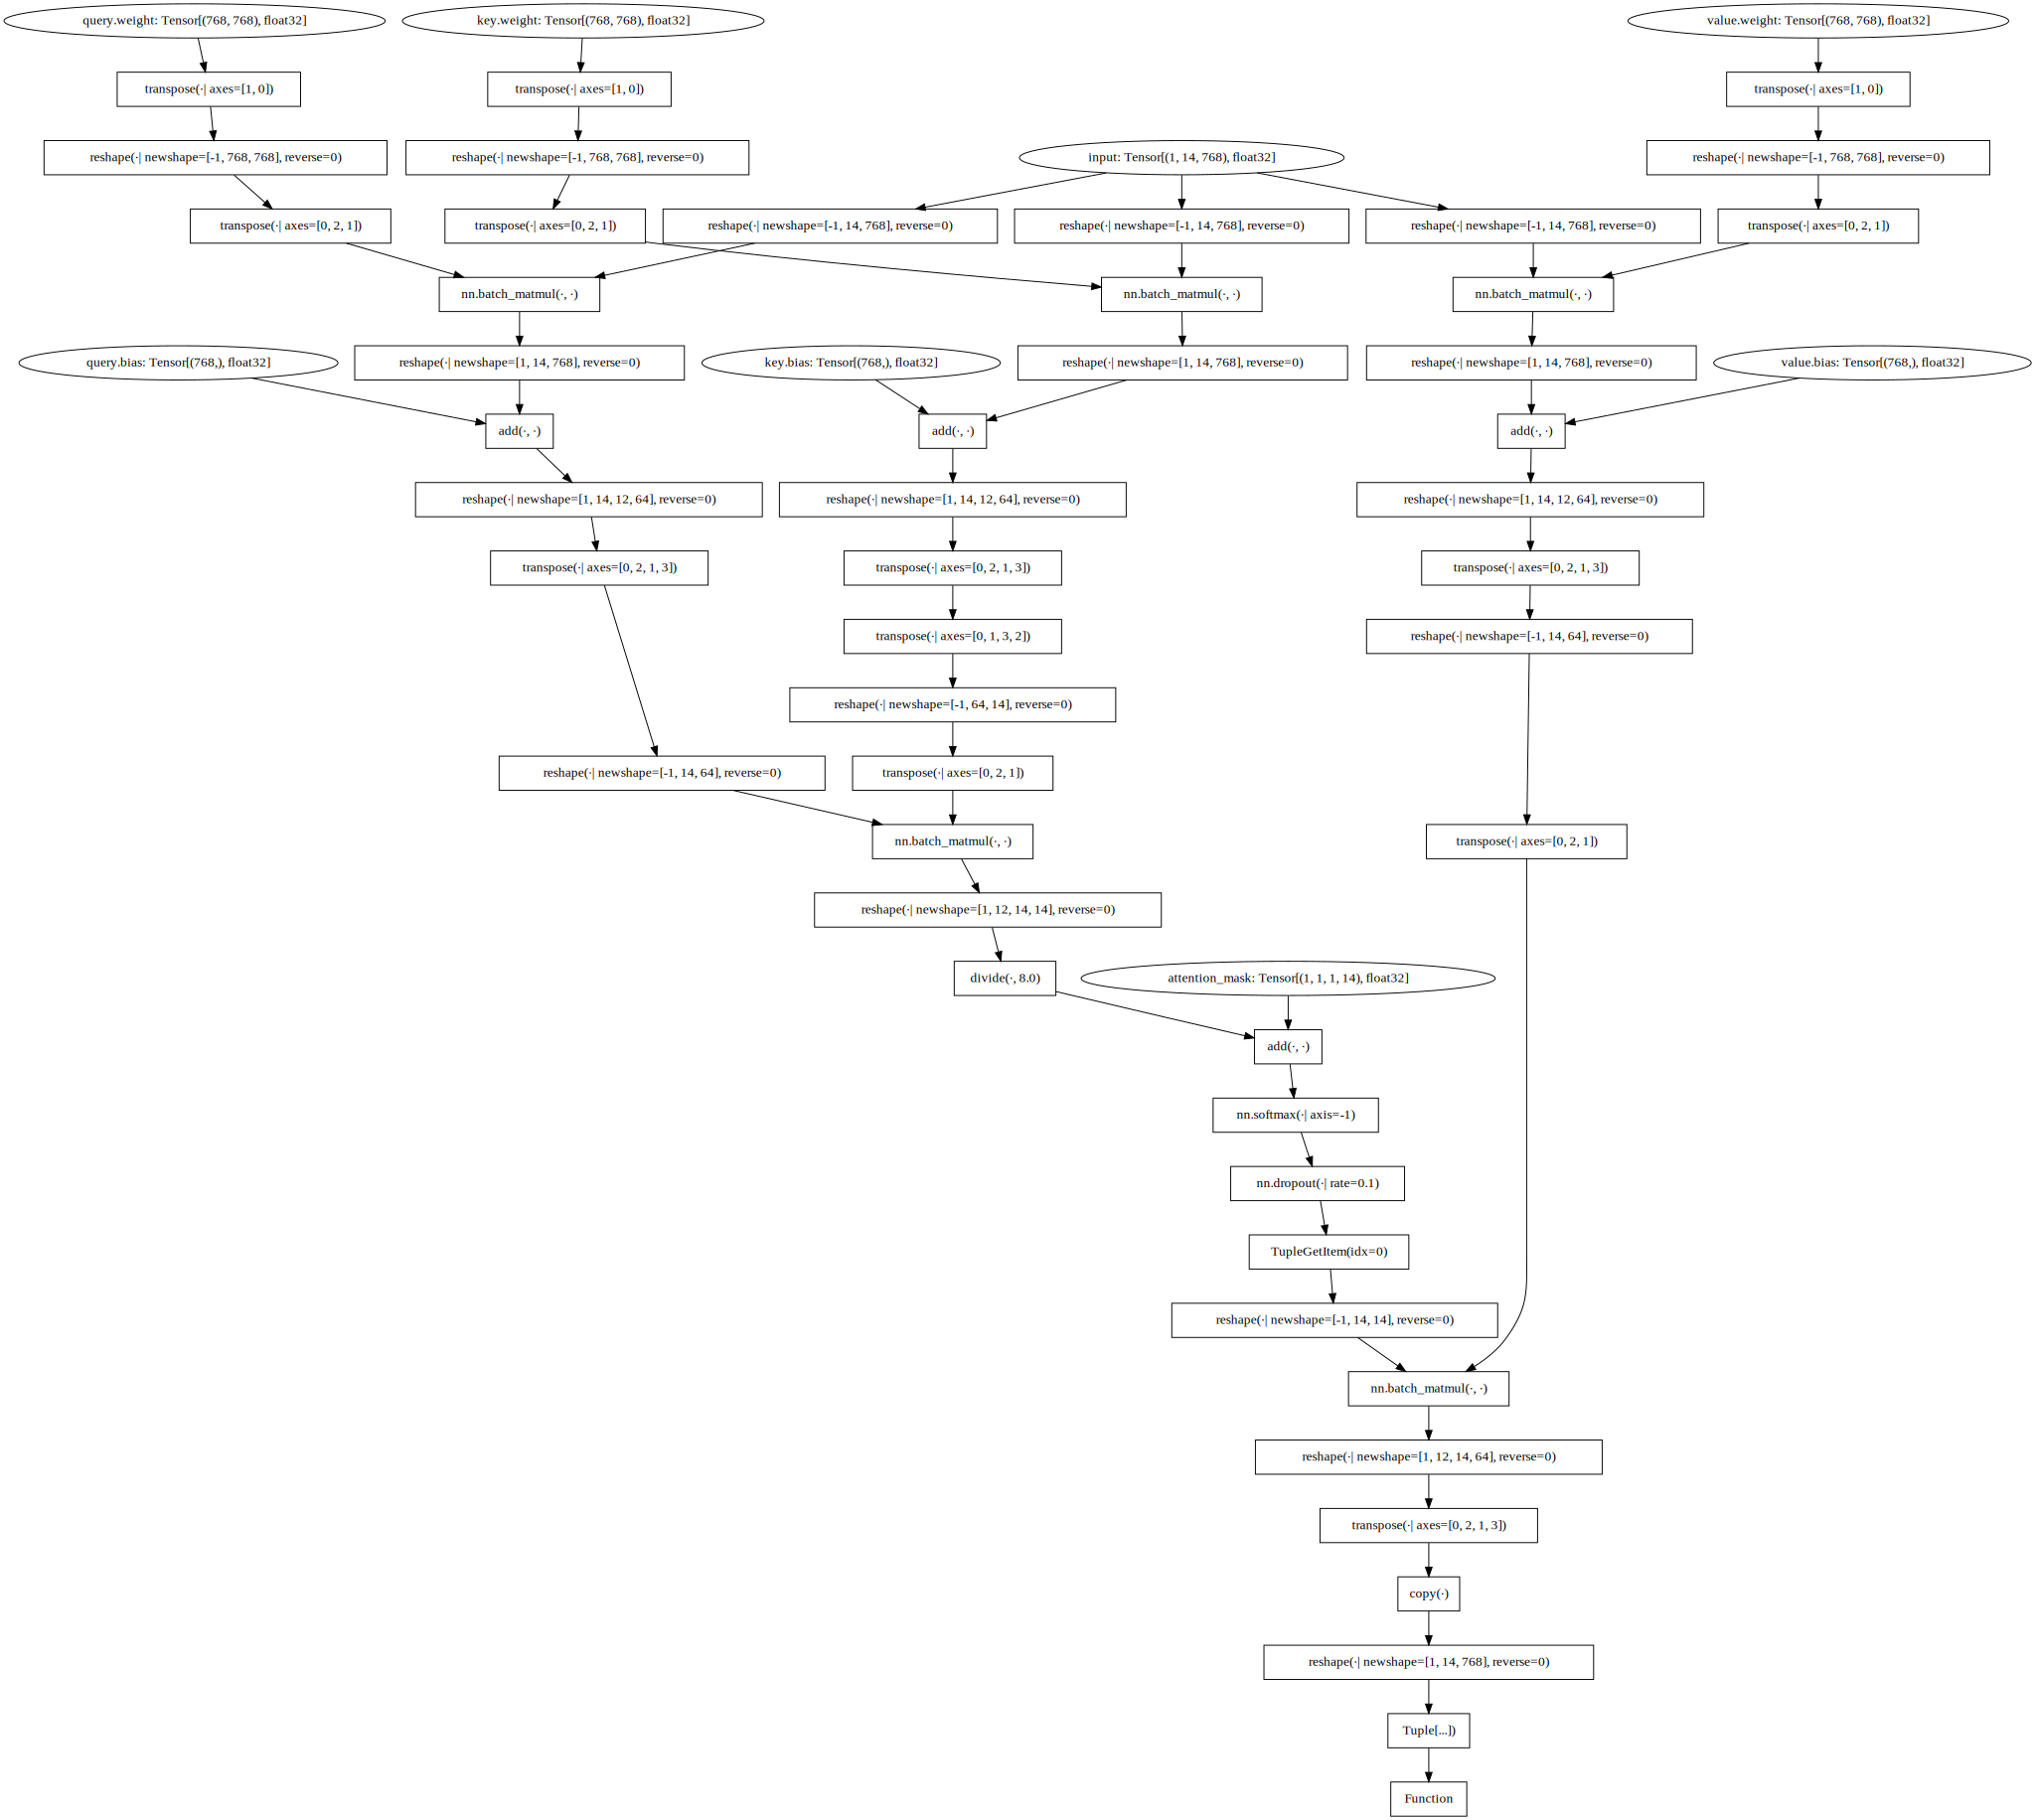

In [27]:
visualize(mod['main'])

In addition to our named inputs, we see a number of unnamed (numbered) variables. These are the neural network parameters.

Let us compile our model.

In [28]:
tvm.relay.backend.compile_engine.get().clear()

with tvm.autotvm.apply_history_best(log_filename):
    with tvm.transform.PassContext(opt_level=3):
        graph, lib, params = tvm.relay.build(mod,
                                     target=target,
                                     target_host=target_host,
                                     params=params)
compiled_module = tvm.contrib.graph_runtime.create(graph, lib, ctx)

One curious thing is that compiling the model will change it in-place. (Which [is a bug we hope to fix](https://github.com/apache/incubator-tvm/pull/5822).) As we see in the figure below, all the parameter variables constants. This is done inplace, but the subsequent optimization steps are done out-of-place, i.e. not reflected in our copy of the module.

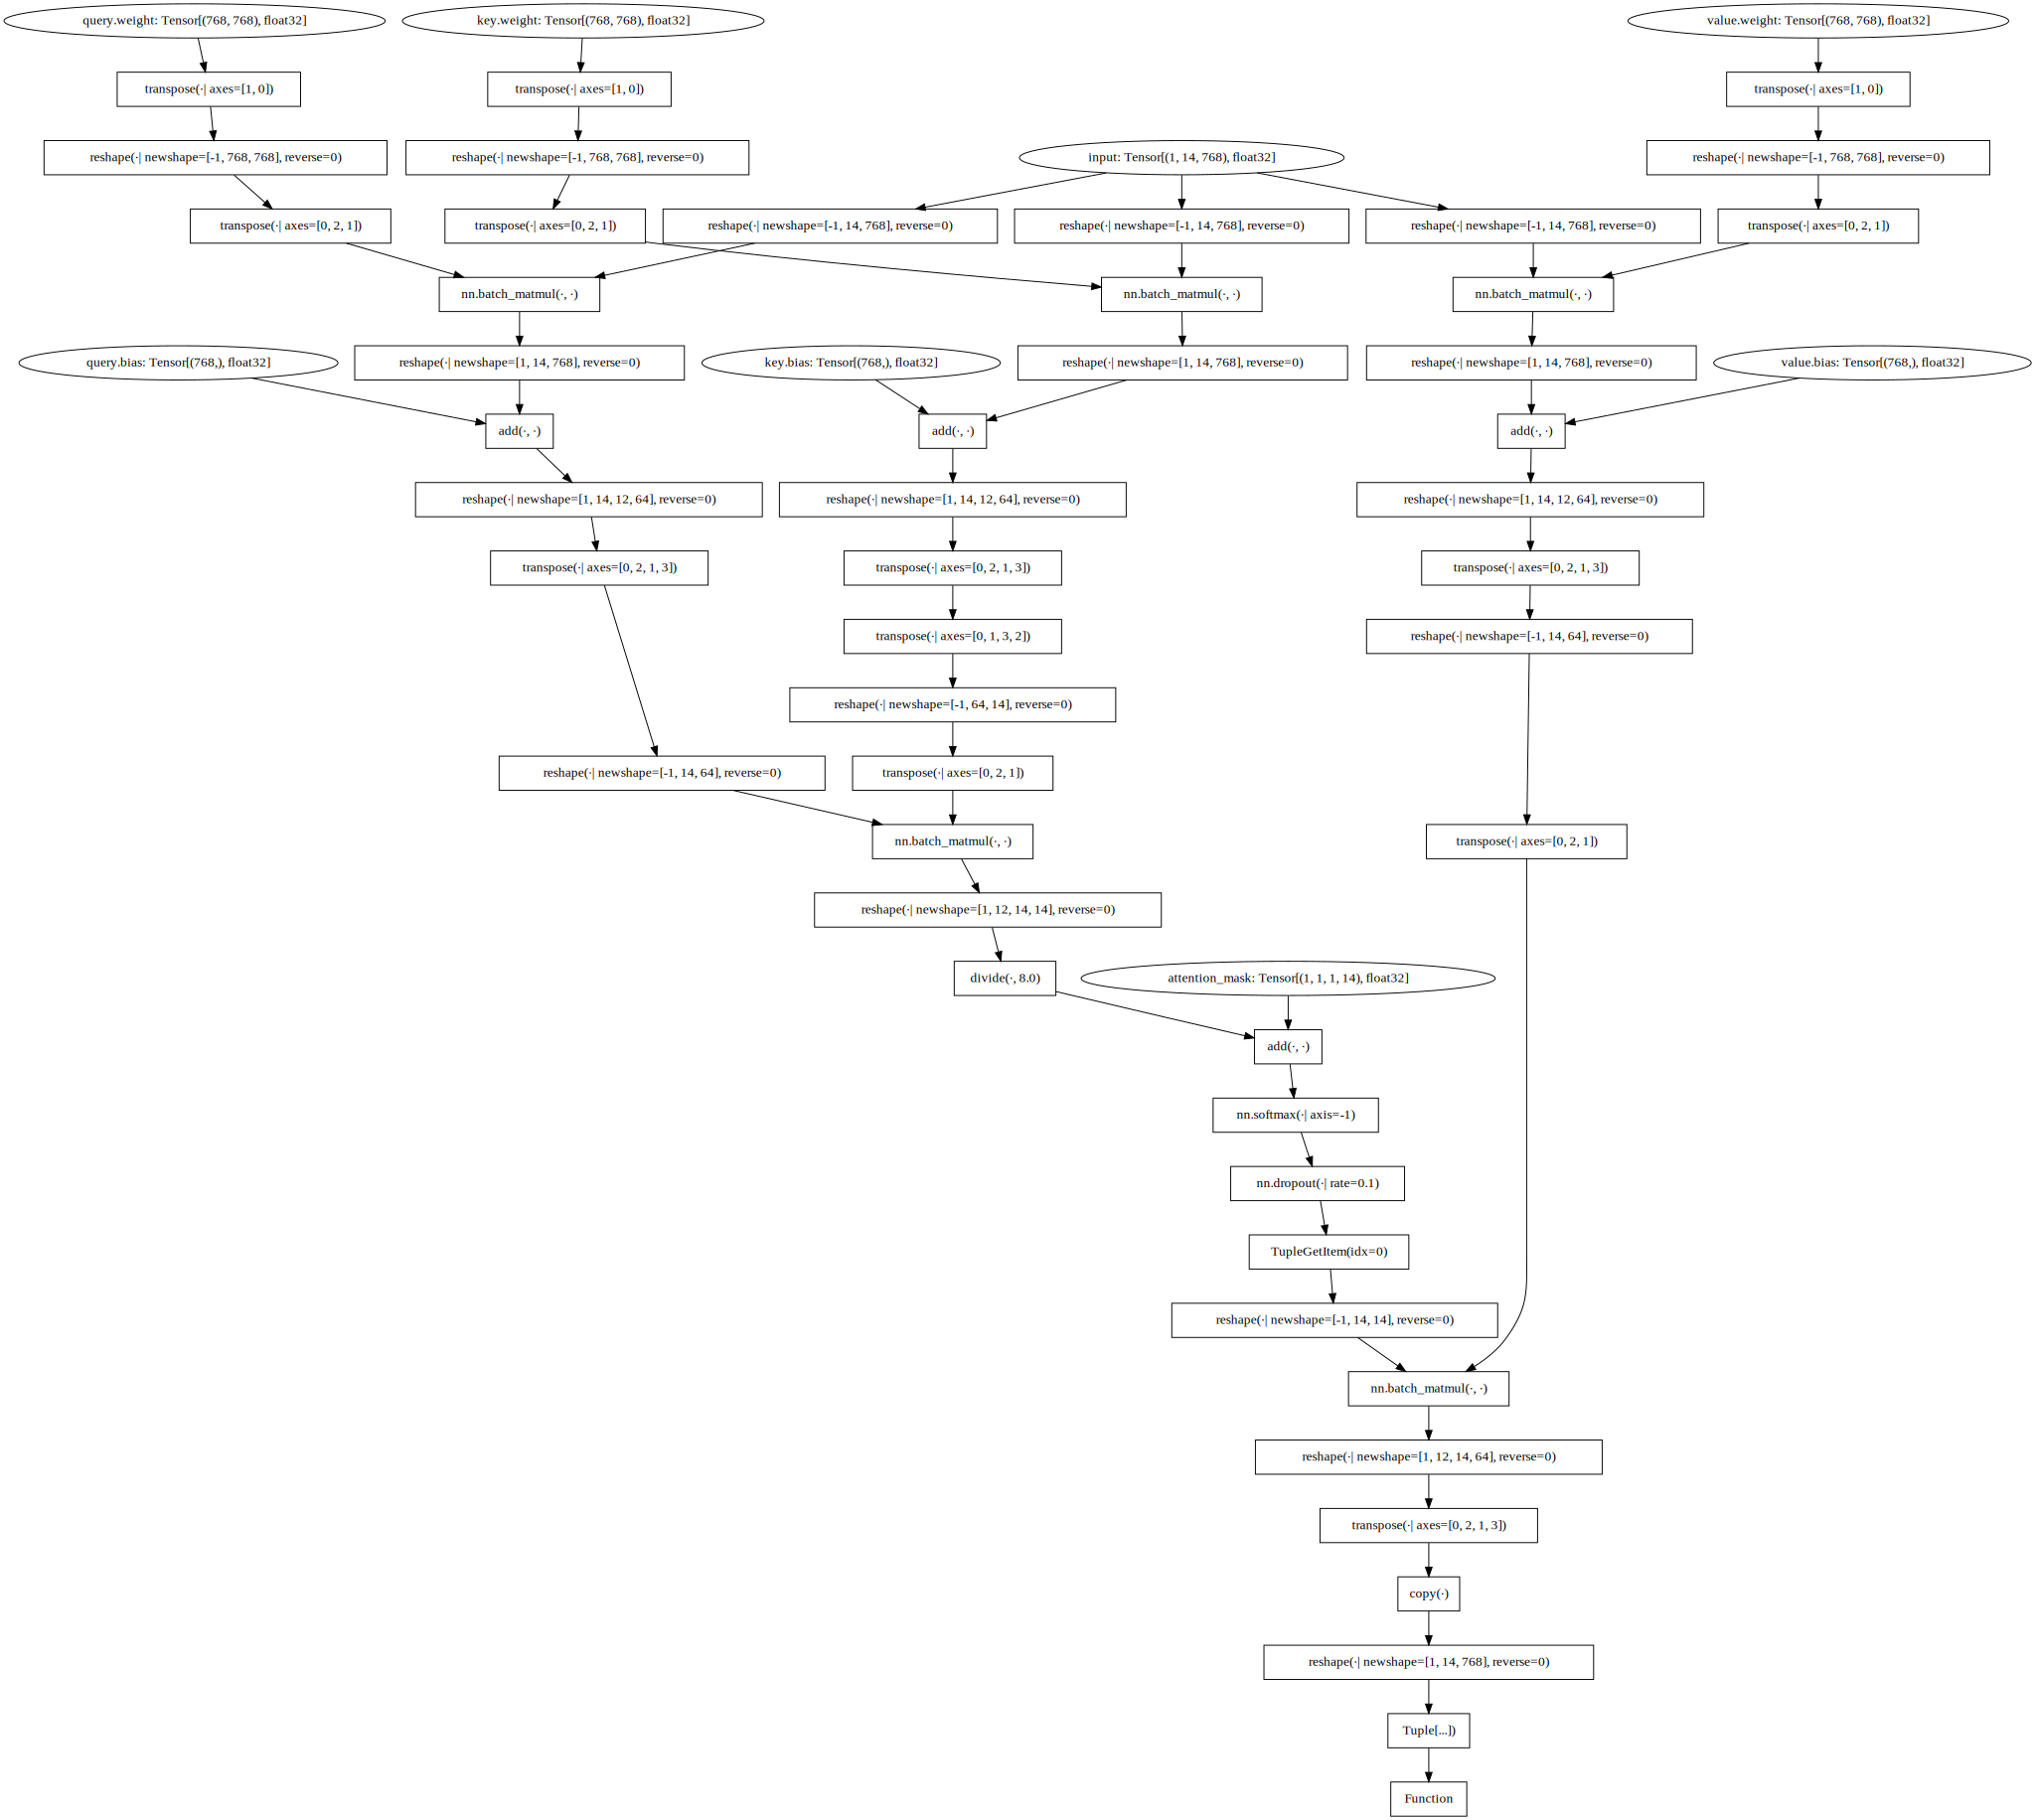

In [29]:
visualize(mod['main'])

Just like the full model, we can run and time our submodule. Let's first check accuracy.

In [30]:
inp_tvm = [tvm.nd.array(i.numpy(), ctx) for i in inp[:2]]

In [31]:
for (n, _), i in zip(shape_list, inp_tvm):
    compiled_module.set_input(n, i)
compiled_module.set_input(**params)

In [32]:
compiled_module.run()
traced_module.cpu()
numpy.abs(compiled_module.get_output(0).asnumpy()-traced_module(*inp[:2])[0].numpy()).max()

2.3841858e-06

And now the timing.

In [33]:
traced_module.cuda()
inp_cuda = [i.cuda() for i in inp[:2]]

In [34]:
def x():
    for i in range(100):
        traced_module(*inp_cuda)
    torch.cuda.synchronize()

x()
%timeit x()

20.3 ms ± 14.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


The back of the envelope calculation here is that with PyTorch we're spending about 0.2ms in this layer, so about 2.4ms on 12 layers - a sizeable part of the 6-7ms overall runtime. Let's compare to TVM.
(A good rule is to never optimize without measuring.)

In [35]:
def y():
    for i in range(100):
        compiled_module.run()
    ctx.sync()
y()
%timeit y()

18.9 ms ± 29.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


So here we are also roughly on par with PyTorch.

One thing we see from the picture is that the input is reshaped three times. There is a TVM optimization pass call Common Subexpression Elimination (CSE) that should combine the three reshapes. But if we run it, it won't do what we want: (We start with a freshly translated module because of the glitch above.)

ANTLR runtime and generated code versions disagree: 4.8!=4.7.2
ANTLR runtime and generated code versions disagree: 4.8!=4.7.2


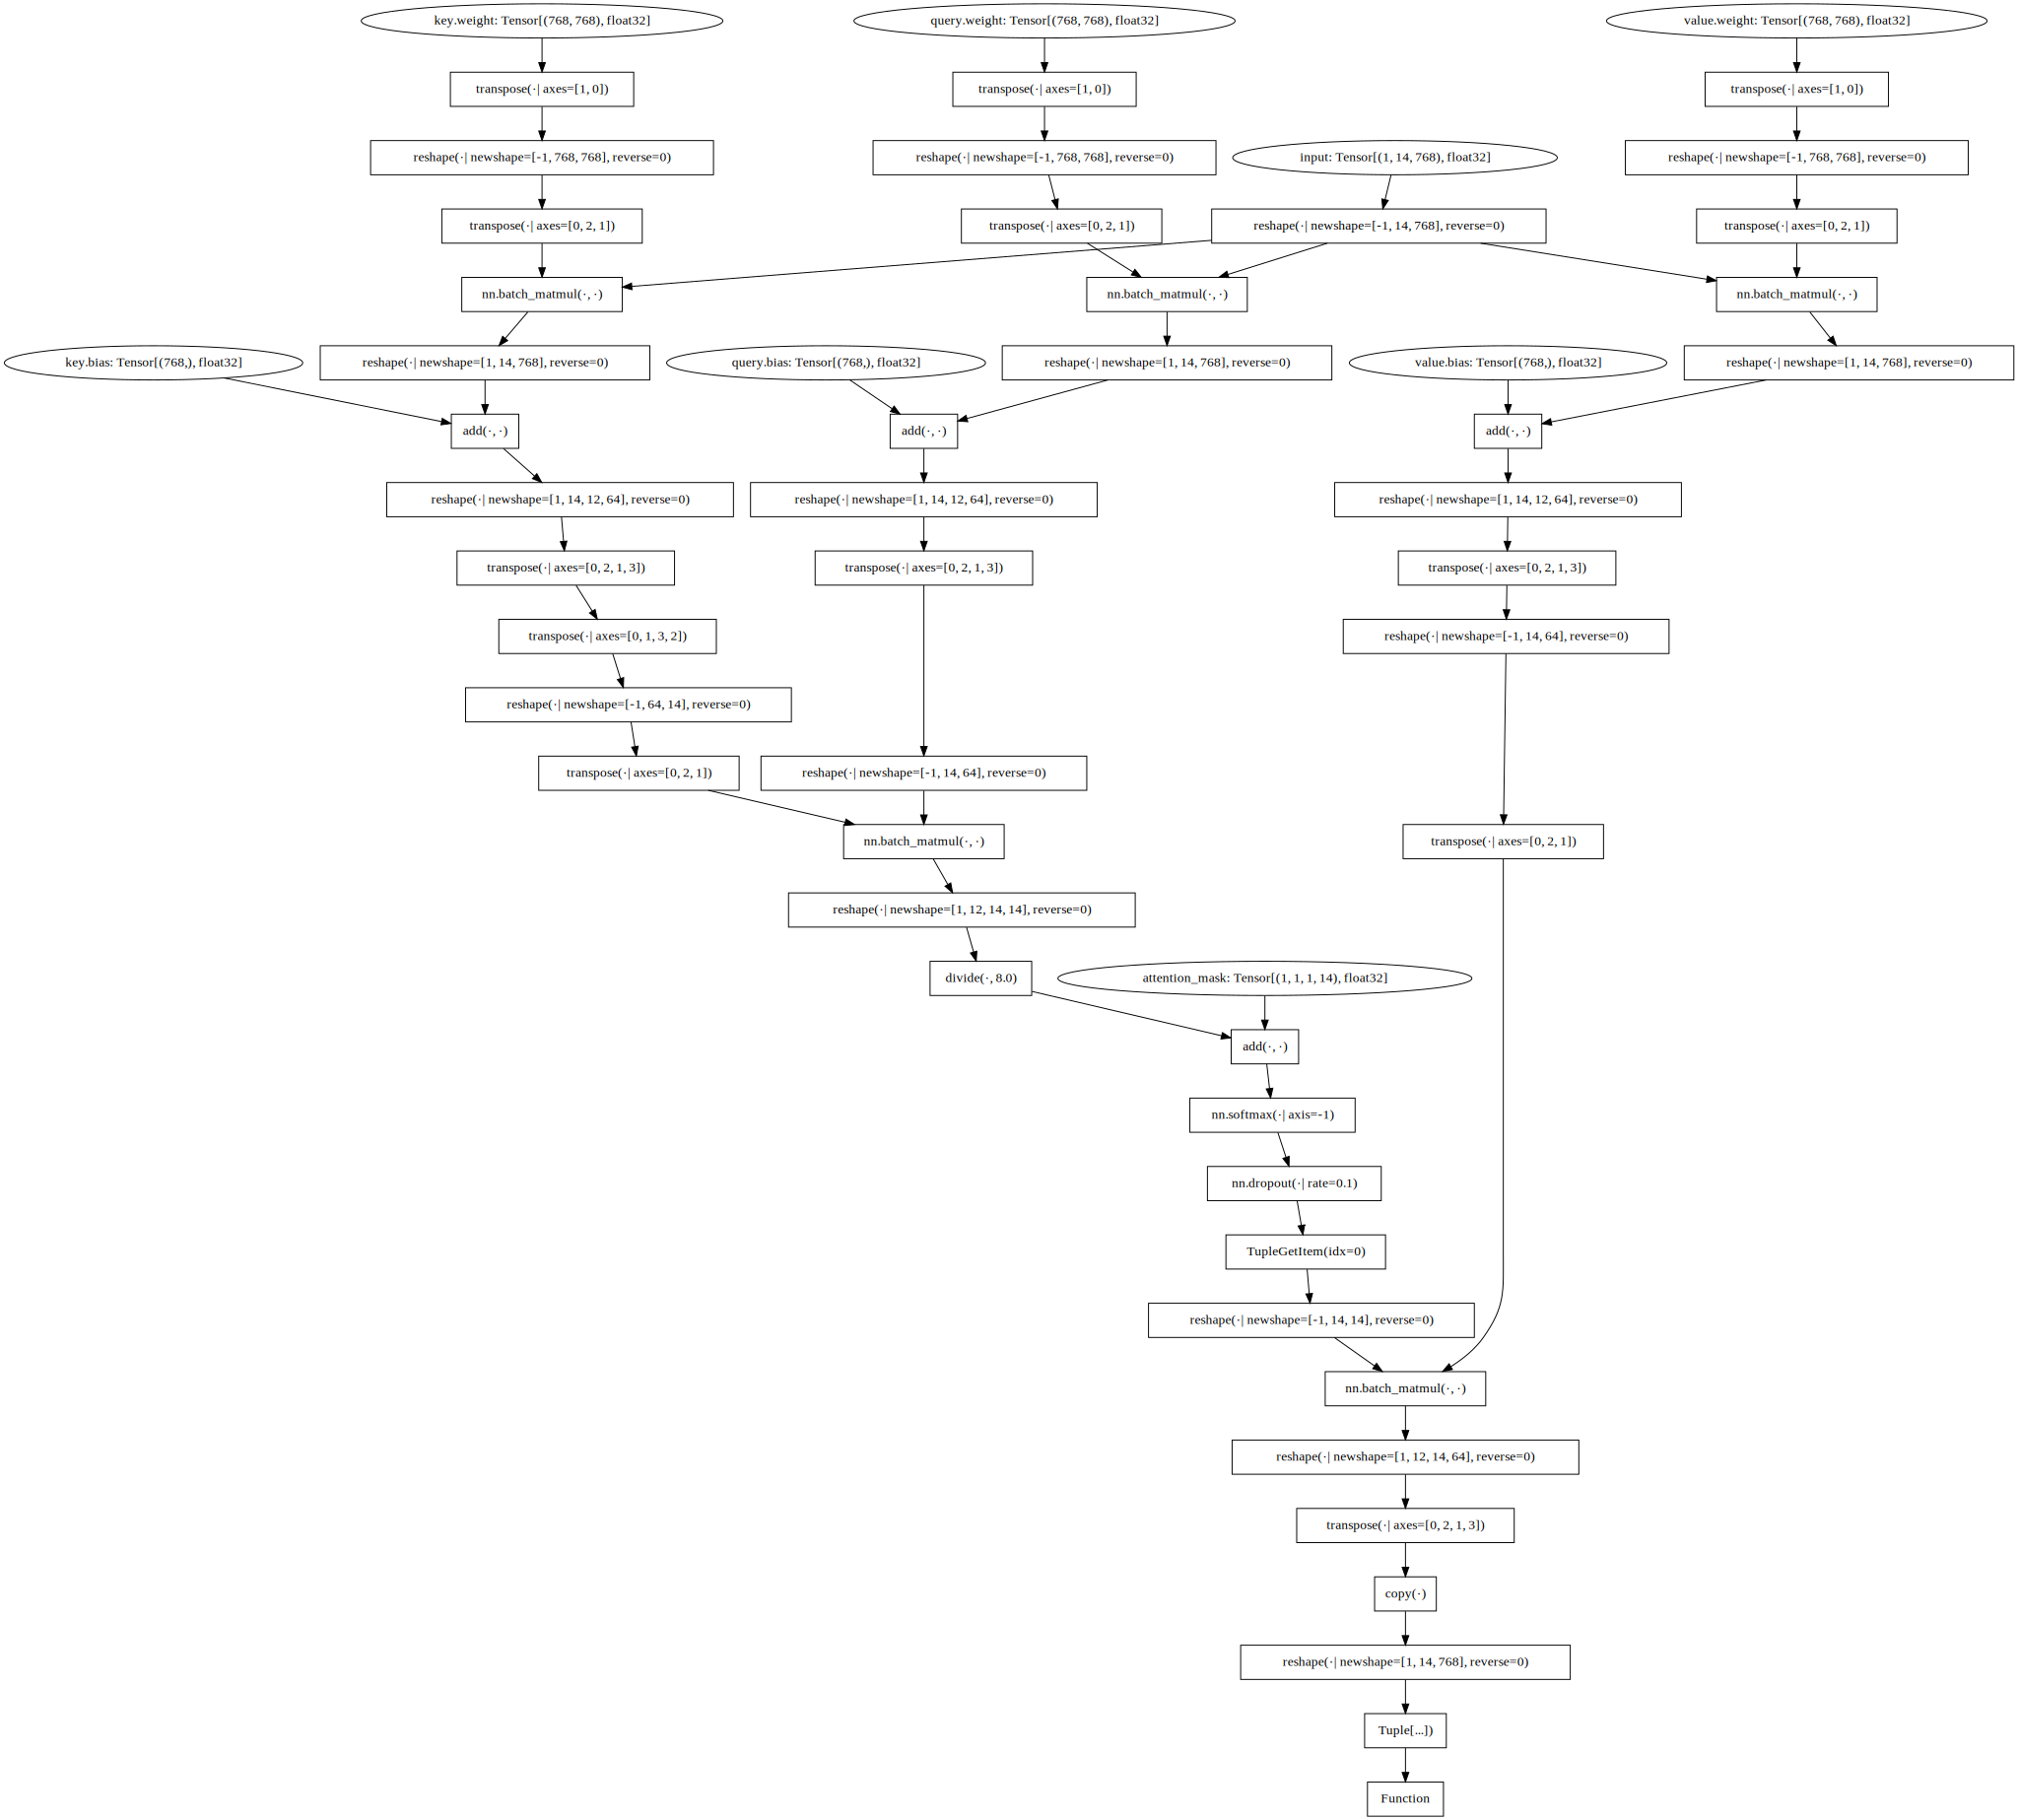

In [36]:
mod, params = tvm.relay.frontend.pytorch.from_pytorch(traced_module, shape_list, default_dtype="float32")
new_mod = tvm.relay.transform.EliminateCommonSubexpr()(mod)
visualize(new_mod['main'])

The problem - not apparent form the picture because I merged the small shape tensors into the reshape - is that the three shape tensor inputs to reshape are actually distinct.

The background to this is that the Relay Intermediate Representation that gives us these graphs was initially designed to be very static - the `reshape` would not take a shape input but have shape attributes. Currently, the TVM developers are [experimenting with various approaches to making it dynamic](https://discuss.tvm.ai/t/dynamic-ops-in-relay/6909), with the current form `reshape` being part of the exploration and the CSE pass not having caught up yet. Add to the mix that the PyTorch frontend will generate new shape tensors for every reshape, and now we don't get the `reshape`s merged.

But happily, we can write our own pass fixing that.
Do do this, we need to look at all `reshape` nodes and track shape constants. If we convert them into shape tuples, we can use these tuples as keys into a dictionary. Then we replace the function call with one using the common shape.

In TVM such a pass is implemented by subclassing the expression mutator class `tvm.relay.ExprMutator` and overriding `visit_call`, which needs to ensure two things:

- It needs to visit all the arguments to the call (the predecessors in the relay graph), and
- it needs to return a transformed call in all cases (and so we call `super().visit_call(...)` when for calls that are not for a reshape or where the argument isn't a constant.

We can then run this pass on a function by instantiating and calling `visit` as in `ShapeConstDedupMutator().visit(fn)`. to get a new function. This can be lifted to a pass transforming modules by defining it as a function and using the `tvm.relay.transform.function_pass` decorator.

More information can be found in the [documentation for the Relay pass infrastructure](https://docs.tvm.ai/dev/relay_pass_infra.html#python-frontend) and the [corresponding tutorial](https://docs.tvm.ai/tutorials/dev/relay_pass_infra.html). So let's define our pass and run it followed by a new CSE run and see if the graph has changed.

In [37]:
class ShapeConstDedupMutator(tvm.relay.ExprMutator):
    def __init__(self):
        super().__init__()
        self.shape_consts = {}

    def visit_call(self, call):
        if (isinstance(call.op, tvm.ir.Op) and call.op.name == "reshape"
            and (len(call.args) == 1 or isinstance(call.args[1], tvm.relay.Constant))):
            if len(call.args) > 1:
                assert list(call.attrs.newshape) == list(call.args[1].data.asnumpy())
            new_fn = self.visit(call.op)
            new_args = [self.visit(arg) for arg in call.args]
            return tvm.relay.Call(new_fn, new_args[:1], call.attrs)
        return super().visit_call(call)

@tvm.relay.transform.function_pass(opt_level=1)
def ShapeConstDedup(fn, mod, ctx):
    return ShapeConstDedupMutator().visit(fn)

new_mod = ShapeConstDedup(new_mod)
new_mod = tvm.relay.transform.EliminateCommonSubexpr()(new_mod)

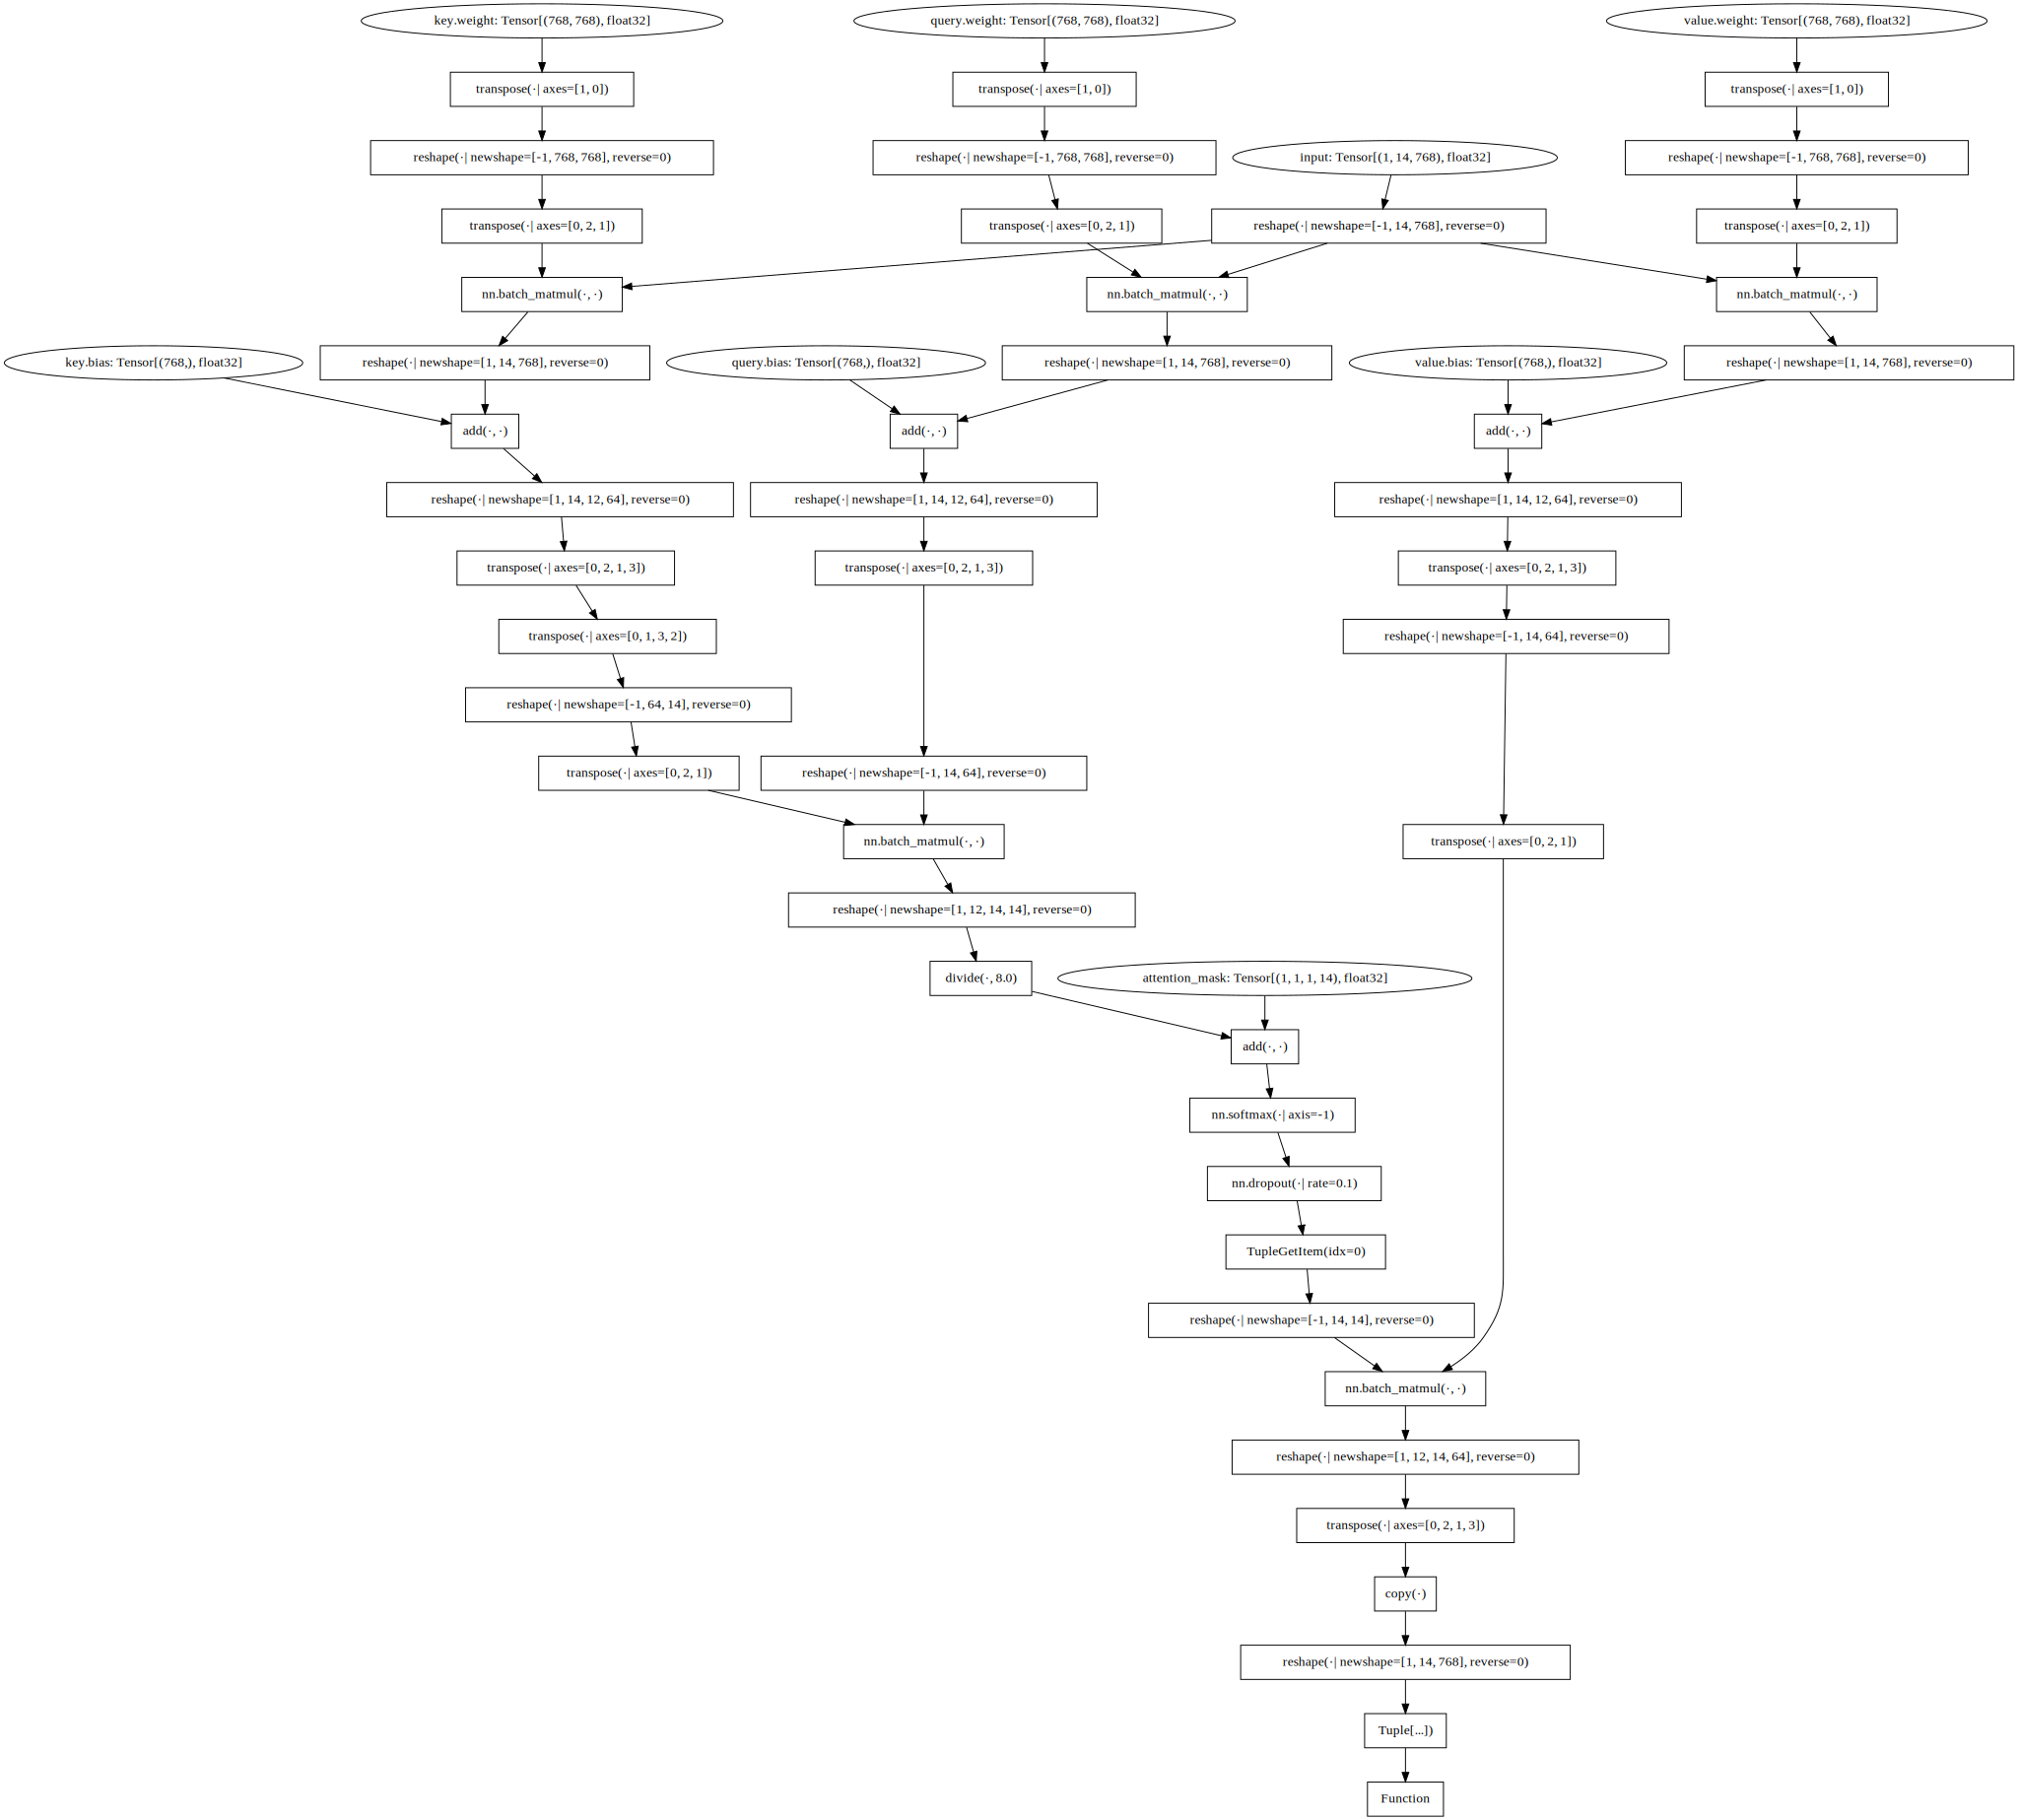

In [38]:
visualize(new_mod["main"])

Ha, now the reshapes have been fused and the three matrix multiplications have a common argument. But the parameters that are then reshaped and transposed. Can we get rid of that, too? 
Yes. And for that we would first _bind_ the parameters, i.e. put them into the model. Then the parameters have become constants instead of input nodes. 

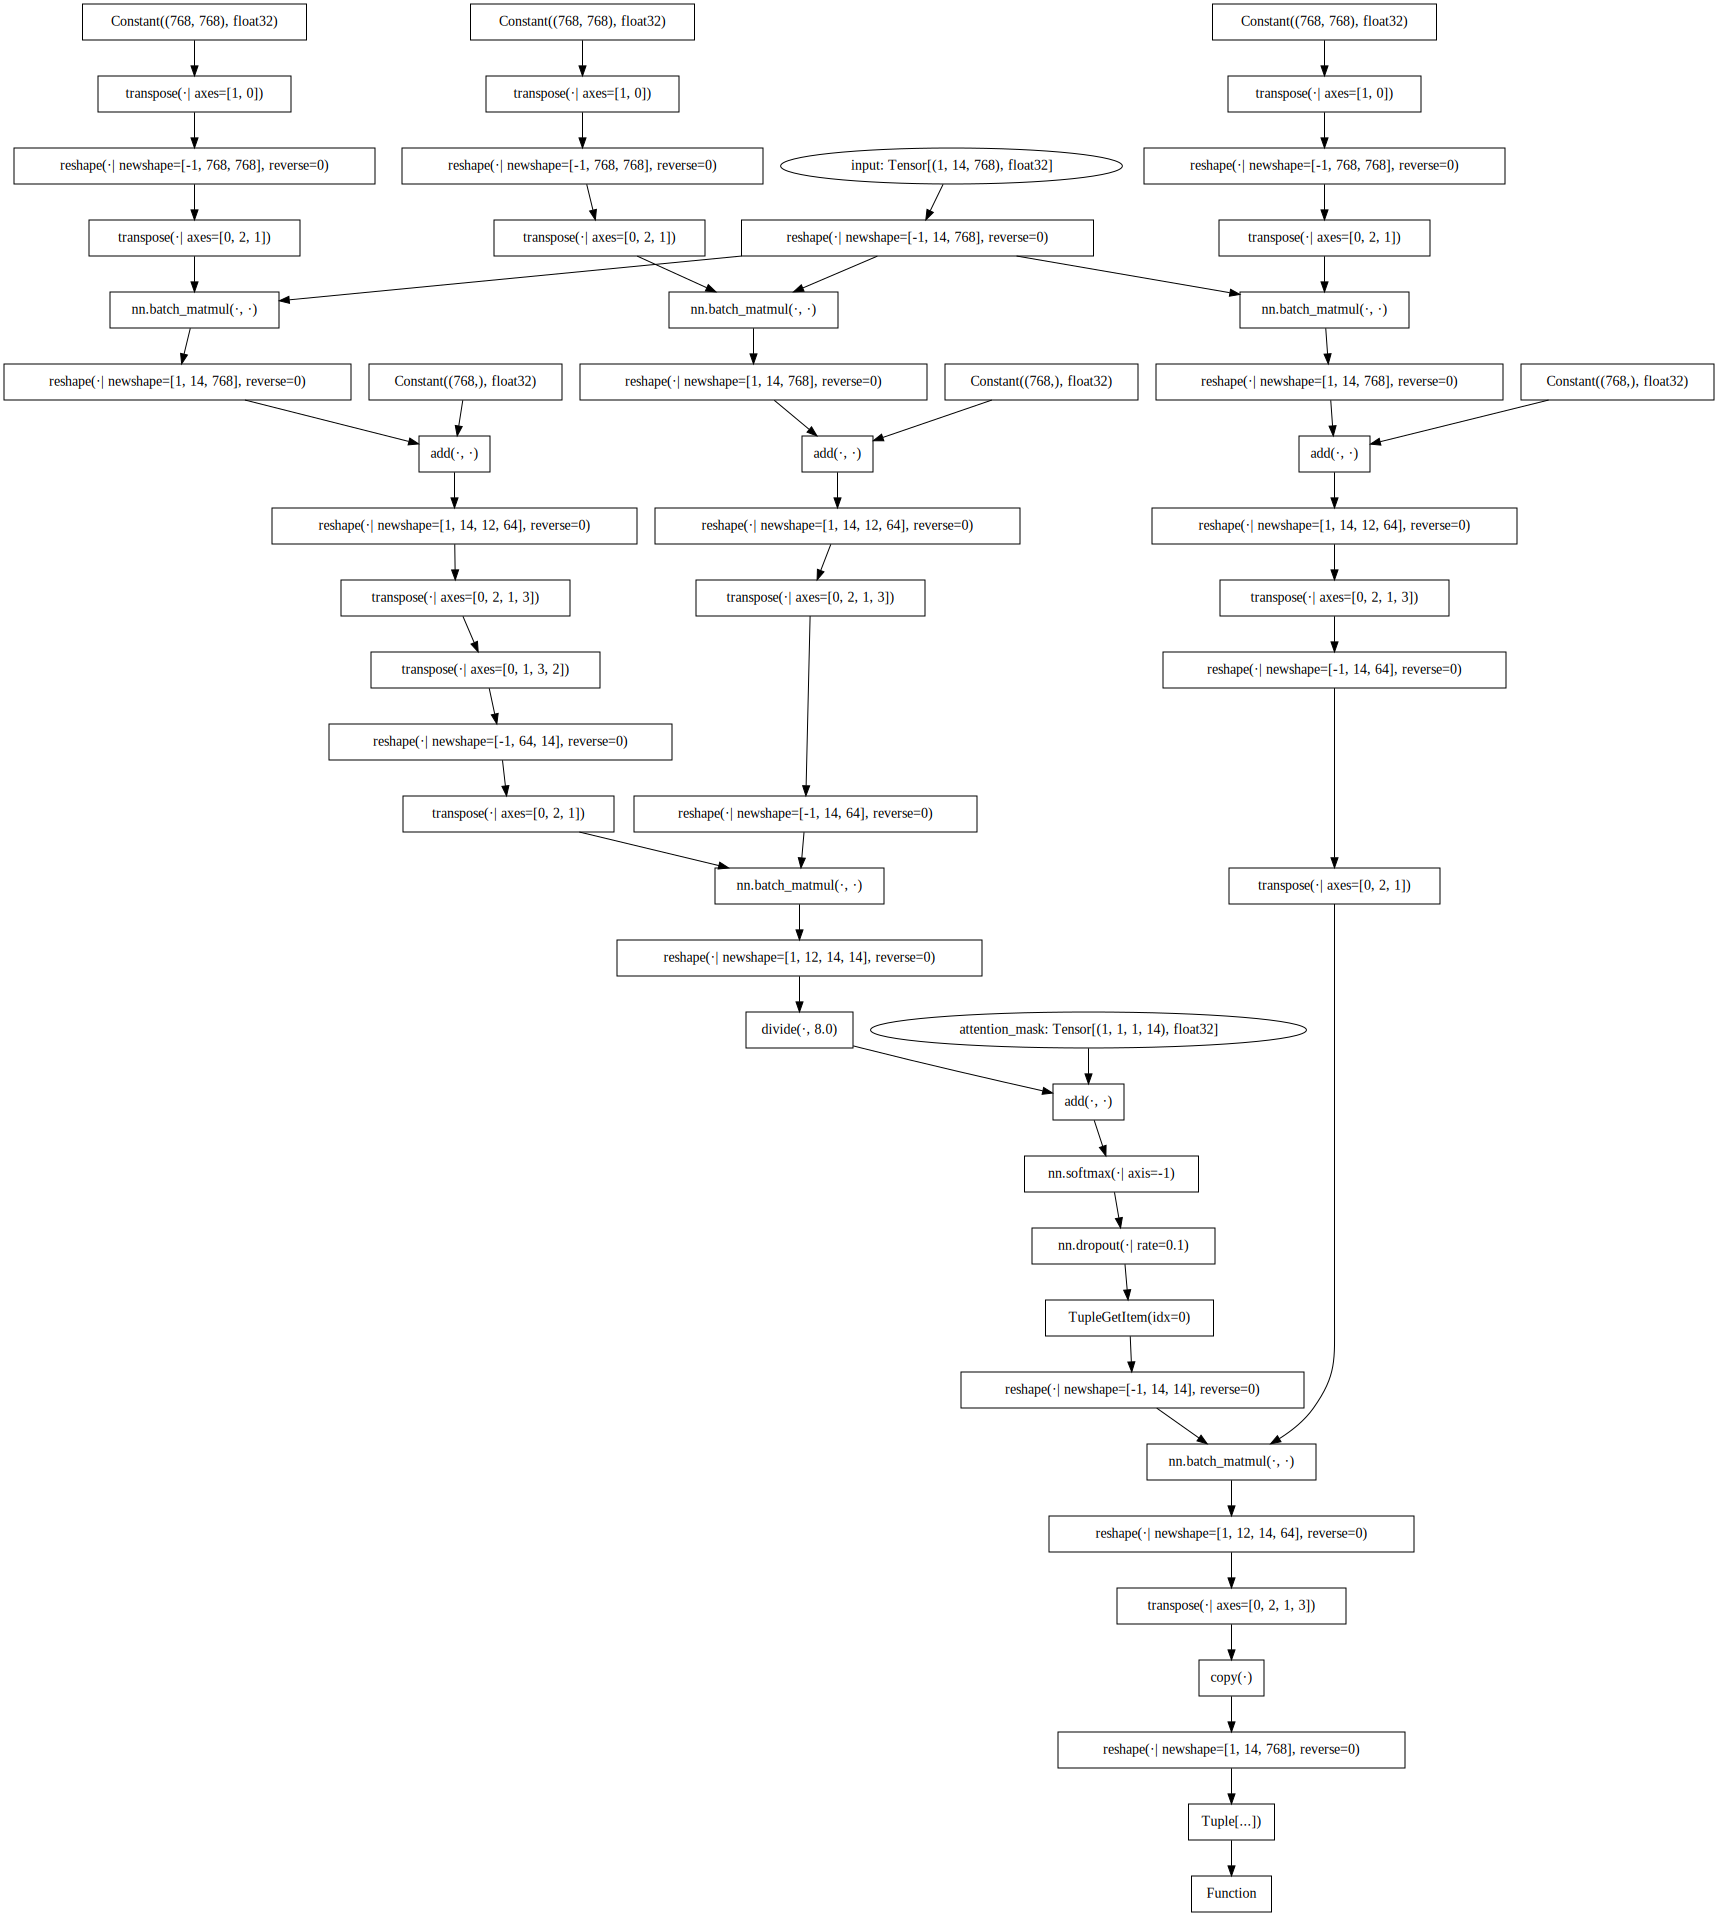

In [39]:
BindPass = tvm.relay.transform.function_pass(lambda fn, new_mod, ctx: 
                                             tvm.relay.build_module.bind_params_by_name(fn, params),
                                opt_level=1)
new_mod = BindPass(new_mod)
visualize(new_mod["main"])

With the `Foldconstant` pass, we can propagate the constants through the `transpose`s and `reshape`s to move them closer to the matmuls.

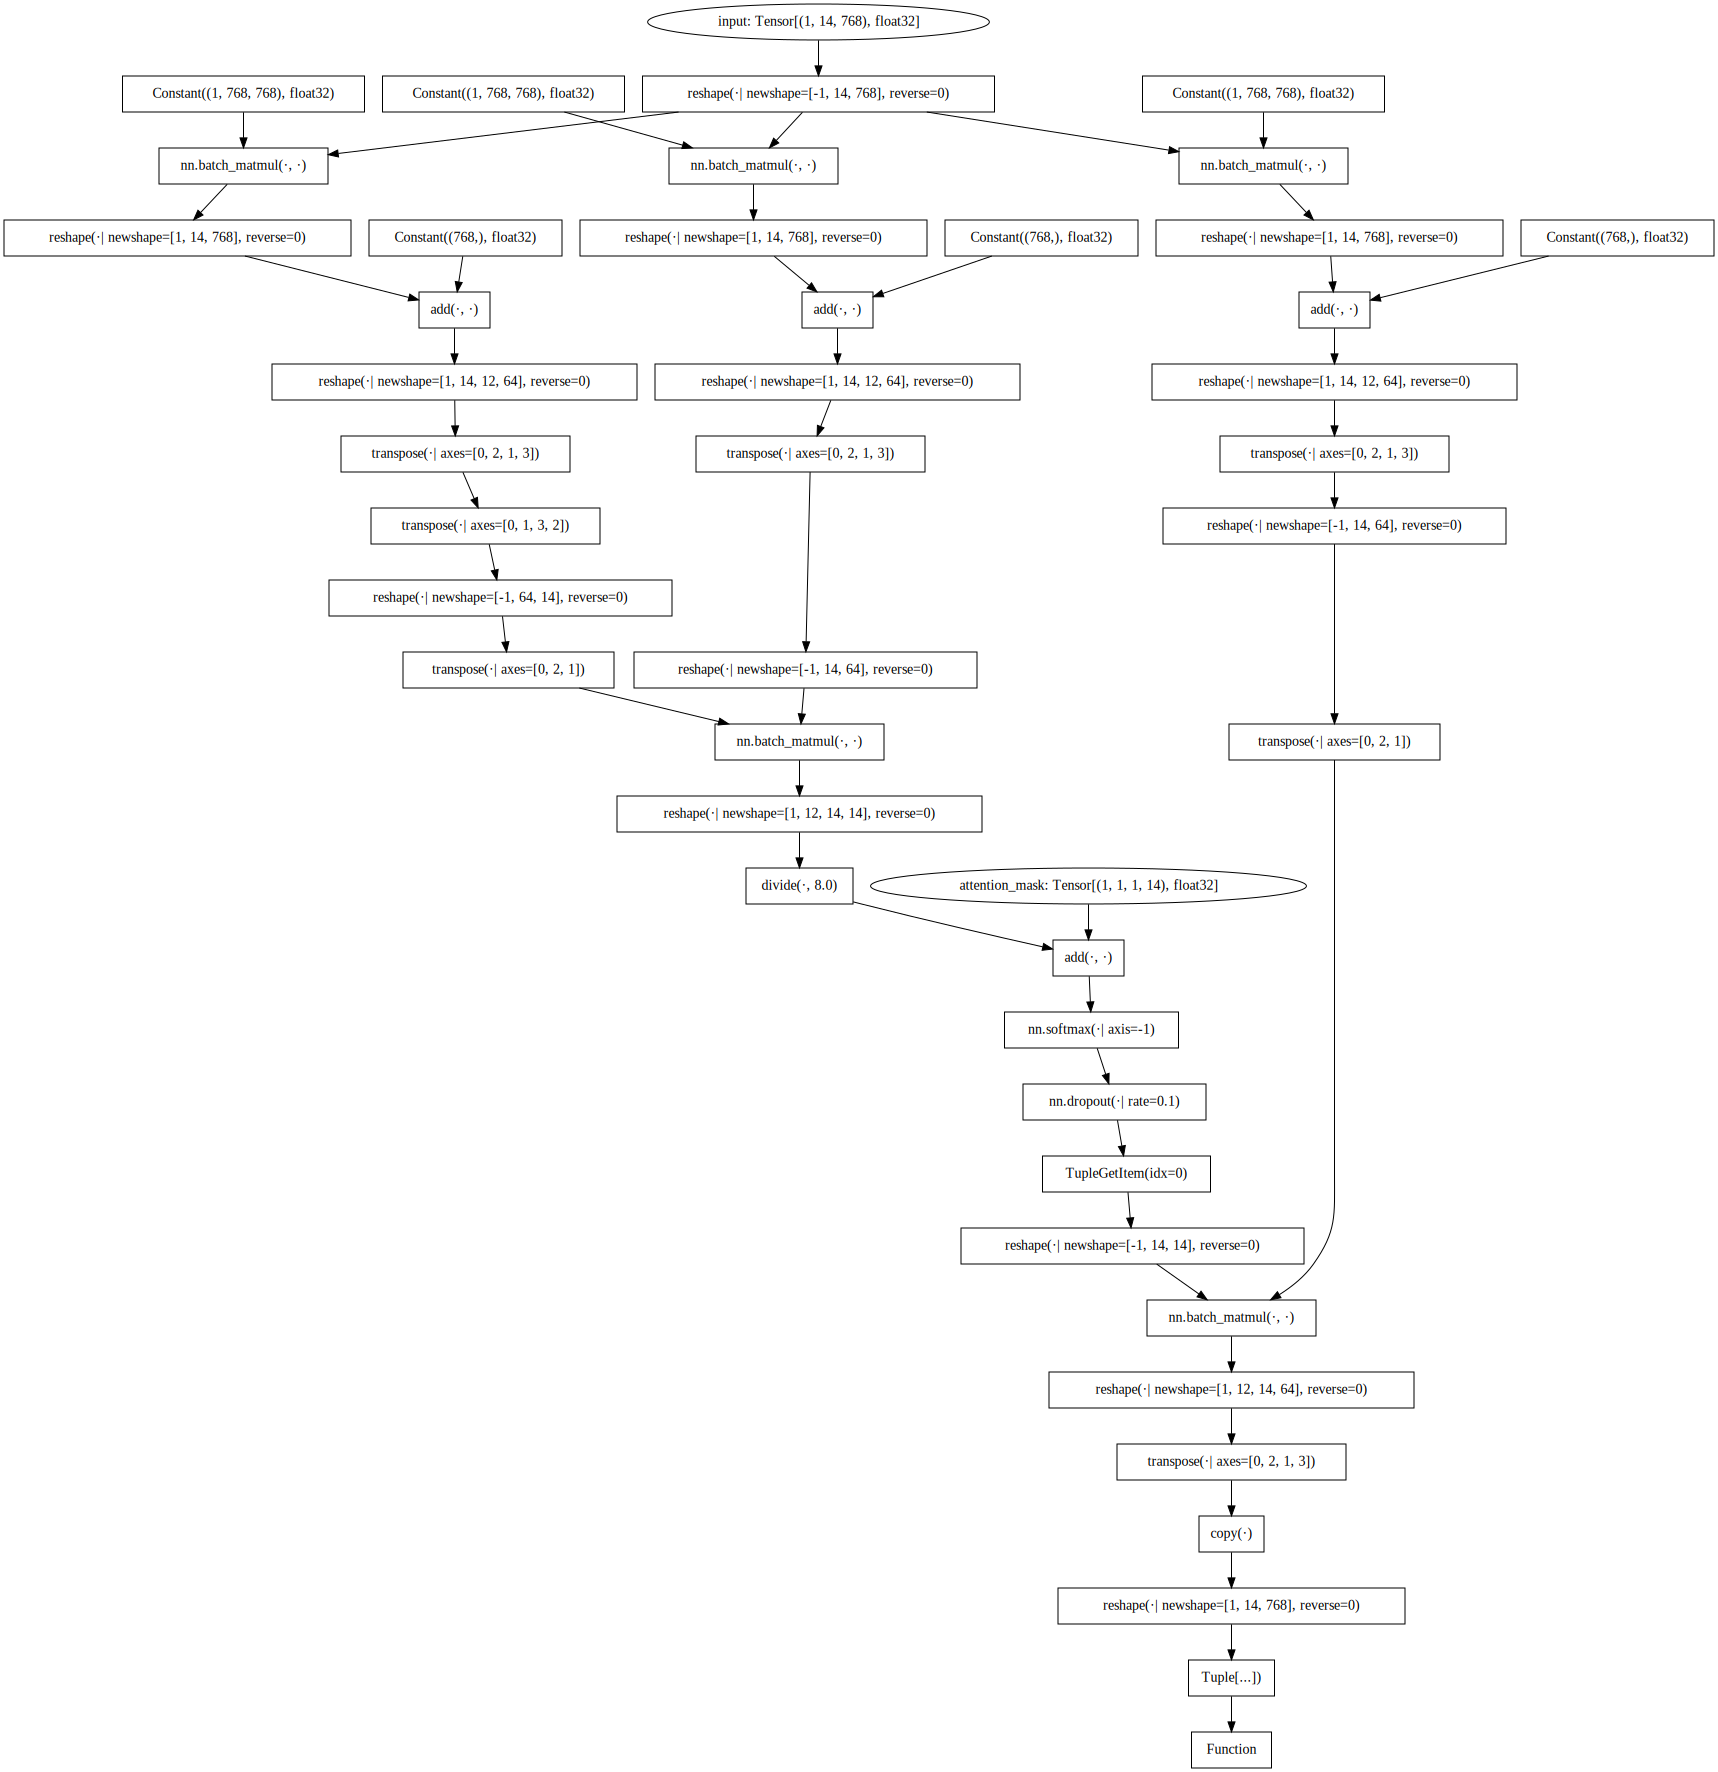

In [40]:
new_mod = tvm.relay.transform.FoldConstant()(new_mod)
visualize(new_mod["main"])

And now comes an interesting trick. It is more efficient to merge the three batch matmuls with the same input into a single `batch_matmul`. We implemented a pass doing this in [TVM PR 5791](https://github.com/apache/incubator-tvm/pull/5791). So let's call it and also have another constant-folding pass.

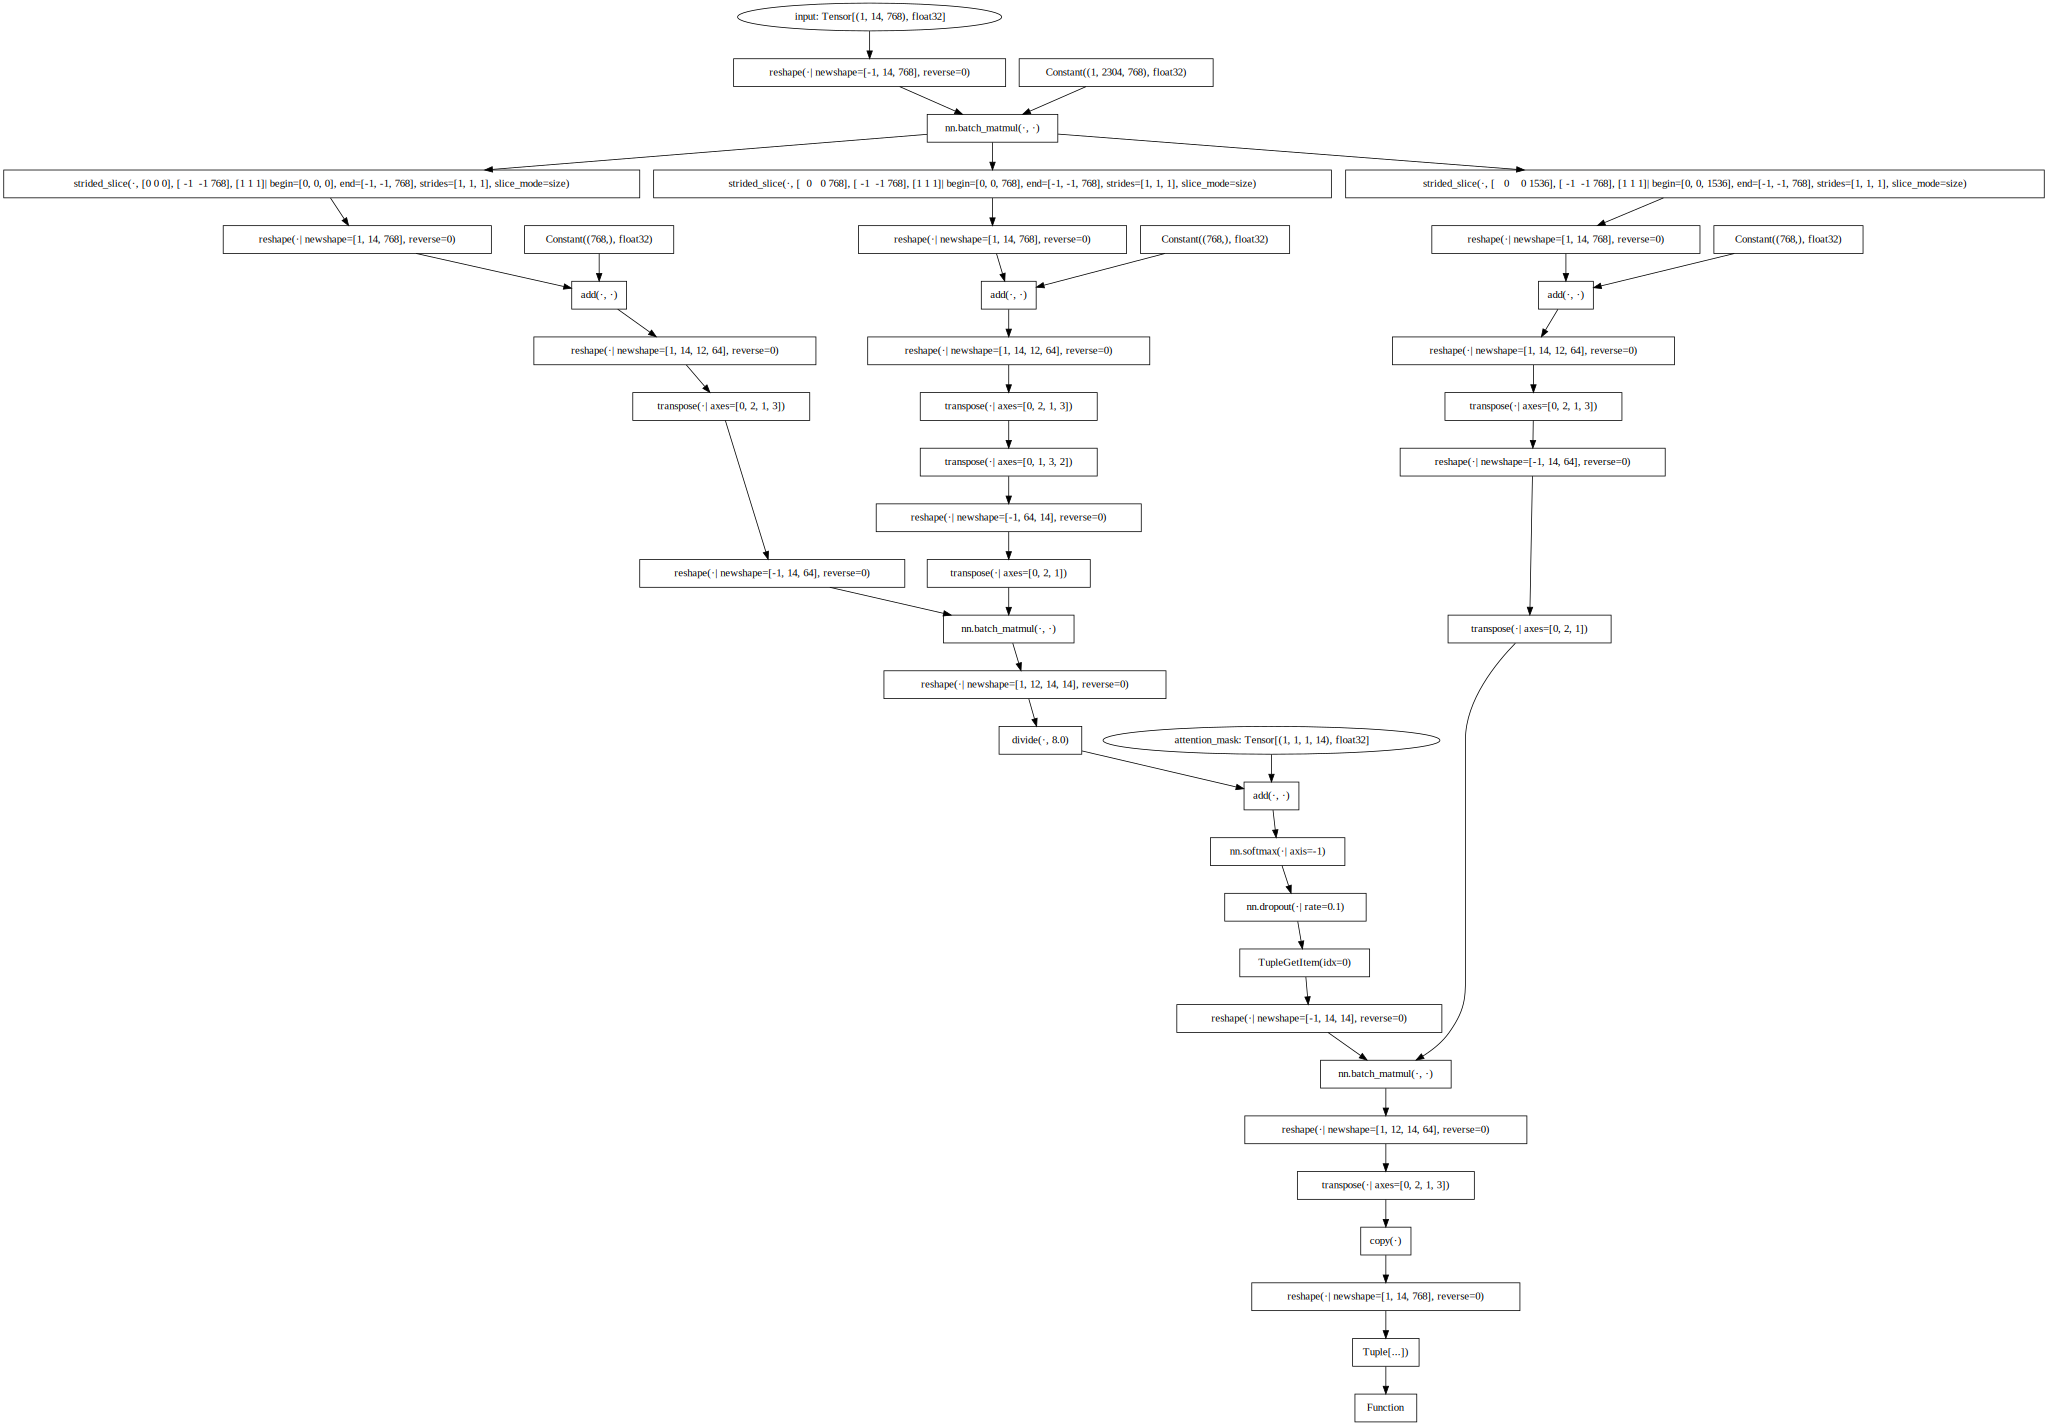

In [41]:
new_mod = tvm.relay.transform.CombineParallelBatchMatmul()(new_mod)
new_mod = tvm.relay.transform.FoldConstant()(new_mod)
visualize(new_mod["main"])

Awesome. Let's run it and see whether we still get the same result.

In [42]:
tvm.relay.backend.compile_engine.get().clear()

with tvm.autotvm.apply_history_best(log_filename):
    with tvm.transform.PassContext(opt_level=3):
        graph, lib, params = tvm.relay.build(new_mod,
                                     target=target,
                                     target_host=target_host,
                                     params=params)
compiled_module = tvm.contrib.graph_runtime.create(graph, lib, ctx)


In [43]:
for (n, _), i in zip(shape_list, inp_tvm):
    compiled_module.set_input(n, i)
compiled_module.set_input(**params)
compiled_module.run()
traced_module.cpu()
numpy.abs(compiled_module.get_output(0).asnumpy()-traced_module(*inp[:2])[0].numpy()).max()

2.3841858e-06

In [44]:
def y():
    for i in range(100):
        compiled_module.run()
    ctx.sync()
y()
%timeit y()

26 ms ± 11 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Now it works, but it's slow again. Oh yeah, that's because we got the missing configuration warnings. So let's get back to tuning.

In [45]:
tasks = tvm.autotvm.task.extract_from_program(new_mod["main"], target=target, params=params)
tasks

[Task(func_name=batch_matmul.cuda, args=(('TENSOR', (12, 14, 14), 'float32'), ('TENSOR', (12, 64, 14), 'float32')), kwargs={}, workload=('batch_matmul.cuda', ('TENSOR', (12, 14, 14), 'float32'), ('TENSOR', (12, 64, 14), 'float32'))),
 Task(func_name=batch_matmul.cuda, args=(('TENSOR', (12, 14, 64), 'float32'), ('TENSOR', (12, 14, 64), 'float32')), kwargs={}, workload=('batch_matmul.cuda', ('TENSOR', (12, 14, 64), 'float32'), ('TENSOR', (12, 14, 64), 'float32'))),
 Task(func_name=batch_matmul.cuda, args=(('TENSOR', (1, 14, 768), 'float32'), ('TENSOR', (1, 2304, 768), 'float32')), kwargs={}, workload=('batch_matmul.cuda', ('TENSOR', (1, 14, 768), 'float32'), ('TENSOR', (1, 2304, 768), 'float32')))]

In [46]:
log_filename = 'bert-tuning.stage2.log'

In [48]:
#do_tune(tasks, log_filename)

In [49]:
tvm.relay.backend.compile_engine.get().clear()

target = 'rocm -model=gfx906'
target_host = 'llvm'
ctx = tvm.context(target)
with tvm.autotvm.apply_history_best(log_filename):
    with tvm.transform.PassContext(opt_level=3):
        graph, lib, params = tvm.relay.build(new_mod,
                                     target=target,
                                     target_host=target_host,
                                     params=params)
compiled_module = tvm.contrib.graph_runtime.create(graph, lib, ctx)


In [50]:
for (n, _), i in zip(shape_list, inp_tvm):
    compiled_module.set_input(n, i)
compiled_module.set_input(**params)
compiled_module.run()
traced_module.cpu()
numpy.abs(compiled_module.get_output(0).asnumpy()-traced_module(*inp[:2])[0].numpy()).max()

2.3841858e-06

In [51]:
def y():
    for i in range(100):
        compiled_module.run()
    ctx.sync()
y()
%timeit y()

12.4 ms ± 3.09 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


So we went from about 0.2ms to about 0.13-0.15ms, a nice speedup. By our handwavy calculation, this should cut 0.6-0.8ms from the total runtime, or somewhere between 5%-10%. Let's check.

## Results on the overall BERT model after optimization

Let's define a function combining the optimization passes from above and run it on the entire BERT model.
We go through the same exercise as above.

In [52]:
def run_passes(mod, params):
    #new_mod = ShapeConstDedup(mod)
    new_mod = mod
    new_mod = tvm.relay.transform.EliminateCommonSubexpr()(new_mod)
    BindPass = tvm.relay.transform.function_pass(lambda fn, new_mod, ctx: 
                                             tvm.relay.build_module.bind_params_by_name(fn, params),
                                opt_level=1)
    new_mod = BindPass(new_mod)
    new_mod = tvm.relay.transform.FoldConstant()(new_mod)
    new_mod = tvm.relay.transform.CombineParallelBatchMatmul()(new_mod)
    new_mod = tvm.relay.transform.FoldConstant()(new_mod)
    new_mod = tvm.relay.transform.SimplifyInference()(new_mod) # remove dropout
    return new_mod

In [53]:
shape_list = [(i.debugName().split('.')[0], i.type().sizes()) for i in  list(traced_model.graph.inputs())[1:]]
shape_list


[('input_ids', [1, 14]), ('attention_mask', [1, 14])]

In [54]:
new_mod = run_passes(mod_bert, params_bert)

In [55]:
log_filename = './bert-tuning.full.log'
tasks = tvm.autotvm.task.extract_from_program(new_mod["main"], target=target, params=params)
print(tasks)
#do_tune(tasks, log_filename)

[Task(func_name=batch_matmul.cuda, args=(('TENSOR', (1, 14, 3072), 'float32'), ('TENSOR', (1, 768, 3072), 'float32')), kwargs={}, workload=('batch_matmul.cuda', ('TENSOR', (1, 14, 3072), 'float32'), ('TENSOR', (1, 768, 3072), 'float32'))), Task(func_name=batch_matmul.cuda, args=(('TENSOR', (1, 14, 768), 'float32'), ('TENSOR', (1, 3072, 768), 'float32')), kwargs={}, workload=('batch_matmul.cuda', ('TENSOR', (1, 14, 768), 'float32'), ('TENSOR', (1, 3072, 768), 'float32'))), Task(func_name=batch_matmul.cuda, args=(('TENSOR', (1, 14, 768), 'float32'), ('TENSOR', (1, 768, 768), 'float32')), kwargs={}, workload=('batch_matmul.cuda', ('TENSOR', (1, 14, 768), 'float32'), ('TENSOR', (1, 768, 768), 'float32'))), Task(func_name=batch_matmul.cuda, args=(('TENSOR', (12, 14, 14), 'float32'), ('TENSOR', (12, 64, 14), 'float32')), kwargs={}, workload=('batch_matmul.cuda', ('TENSOR', (12, 14, 14), 'float32'), ('TENSOR', (12, 64, 14), 'float32'))), Task(func_name=batch_matmul.cuda, args=(('TENSOR', (12,

In [56]:
tvm.relay.backend.compile_engine.get().clear()

with tvm.autotvm.apply_history_best(log_filename):
    with tvm.transform.PassContext(opt_level=3):
        graph, lib, params = tvm.relay.build(new_mod,
                                     target=target,
                                     target_host=target_host,
                                     params=params)
module = tvm.contrib.graph_runtime.create(graph, lib, ctx)

In [57]:
module.set_input("input_ids", tt_a)
module.set_input("attention_mask", st_a)
module.set_input(**params)
module.run()
o0 = module.get_output(0)
o1 = module.get_output(1)
(numpy.abs((res_pt[0].cpu().numpy() - o0.asnumpy())).max(), 
 numpy.abs((res_pt[1].cpu().numpy() - o1.asnumpy())).max())

(9.536743e-06, 9.834766e-07)

In [58]:
def x():
    for i in range(100):
        module.run()
    ctx.sync()
x()
%timeit x()

626 ms ± 216 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


So yay, we went from 6.5-7ms in PyTorch to ~6.2ms in TVM. This is a 5%-10% speedup. Note that we have only taking a particular, not very large shape. A more serious analysis would consider more problem shapes.

We could probably take it a bit further yet - e.g. fusing the additions after the batch matmul by handling the reshape, but we'll leave it at this for now. Also we will benefit from further improvements to TVM, so it will be interesting to see how the benchmark improves over time. In particular, the upcoming Ansor tuning mechanism seems promising.

## Some thoughts about the process of converting complex models

As you can see, I have always compared PyTorch with TVM outputs to see if they're good.
Also, when I investigated some inner layer, I grabbed the inputs to that to convert and feed into the TVM model. I do believe that this is a very effective technique.

Sometimes, however, it is difficult to assess whether a deviation between the results is from numerical accuracy or from an error somewhere.
When I initially converted the model, the the SelfAttention submodule output was replicated by the TVM model to about 1e-6. However, the BertLayer conversion had something like 1-e3. I was not entirely clear whether that might be due to accumulated numerical errors or some material deviation somewhere. (This turned out to be the GELU activation, which was converted to FastGELU.)

One of the things I like to do in this case is jump to double precision and check there. Numerical errors should get much smaller, while other deviations would remain of the same order.

We can do this as follows:


In [59]:
inp_double = [i.to(torch.double) for i in debug_wrap.DEBUG_INP[:2]]
debug_wrap.wrapped.to(device="cpu", dtype=torch.double)
traced_module = torch.jit.trace(debug_wrap.wrapped, inp_double).to(dtype=torch.double)
# debug_wrap.wrapped.to(device="cpu", dtype=torch.float) -- careful, this will also modify the traced module's parameterS?!
pt_out_double = traced_module(*inp_double)

shape_list = [(i.debugName().split('.')[0], i.type().sizes()) for i in  list(traced_module.graph.inputs())[1:]]
mod, params = tvm.relay.frontend.pytorch.from_pytorch(traced_module, shape_list, default_dtype="float64")

ANTLR runtime and generated code versions disagree: 4.8!=4.7.2
ANTLR runtime and generated code versions disagree: 4.8!=4.7.2


Running the module and comparing to PyTorch should now have 1e-14 or so deviation.

In [60]:
tvm.relay.backend.compile_engine.get().clear()

with tvm.transform.PassContext(opt_level=3):
    graph, lib, params = tvm.relay.build(mod,
                                     target=target,
                                     target_host=target_host,
                                     params=params)
compiled_module = tvm.contrib.graph_runtime.create(graph, lib, ctx)
for (n, _), i in zip(shape_list, inp_double):
    compiled_module.set_input(n, tvm.nd.array(i.numpy(), ctx=ctx))
compiled_module.set_input(**params)
compiled_module.run()
numpy.abs(compiled_module.get_output(0).asnumpy()-pt_out_double[0].numpy()).max()

2.6645352591003757e-15

Works, great! So here is my advice, if you want to check if something computes the right thing, check in double precision.

# A look behind the scenes.

Before this worked as shown here, we had to close some gaps (but a recent git checkout will include all of them):

- The TVM PyTorch converter did not support inputs other than FP32. We [implemented improved conversion](https://github.com/t-vi/tvm/tree/pytorch_frontend_type_fix), now also included in TVM upsteam.

- The TVM schedule, i.e. the organization of the computation, of the workhorse operation, batch_matmul, was fixed and it was very slow (similar to running without a tuned schedule now). So we [implemented a tuneable schedule](https://github.com/apache/incubator-tvm/pull/5752).
- The PyTorch converter produces batch matmul operations (it could probably also be changed to produce dense layers instead). But as we saw, one of the larger speed advantages is to combine Query Key and Value linear layers, so we implemented [fusing batch matmul operations](https://github.com/apache/incubator-tvm/pull/5791).
- When comparing the computation results, we noticed that the [GELU](https://pytorch.org/docs/master/generated/torch.nn.GELU.html) function was converted to its FastGELU variant. We fixed that. (There is a _fast math_ optimization pass in TVM that does some replacement of the error function, though we didn't check if it yields FastGELU for the GELU expressed with the error function.)
- TVM currently was initially (and still is to a large extent) focussed on static shapes. Recently it experiments with dynamic operations. The dynamic reshape - taking an argument for the target shape - is an early of these experiments, but as seen above, it prevented the fusion of batch matmuls because the common subexpression elimination pass didn't detect that it could merge the identical input reshaping. This has improved recently.

# Acknowledgements

I had many interesting discussions with HugingFace people and Morgan Funtowicz in particular. Also the TVM contributors had many good comments during the review of the patches TVM and on the forums. The creation of this tutorial was sponsored by AMD.

I hope you enjoyed the tutorial, I look forward to your input at <tv@lernapparat.de>